In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

from scipy.optimize import minimize
from scipy.stats import genextreme 

import random

In [2]:
df = pd.read_csv("data/new_era5_data.csv",sep=";")
#Read and load data from csv file

df.time = pd.to_datetime(df.time)
#Convert string to datetime

In [3]:
#Set up start and end date of each year, deletes March 31st if leap year

day_first = pd.date_range("{}-11-01".format(np.min(df.time.dt.year)), "{}-12-01".format(np.max(df.time.dt.year)), freq='12MS')
is_leap = day_first.is_leap_year
day_last = pd.date_range("{}-03-01".format(np.min(df.time.dt.year)), "{}-03-31".format(np.max(df.time.dt.year)), freq='12ME', inclusive='right')
dt1 = day_last[~is_leap]
dt2 = day_last[is_leap] - timedelta(days=1)
day_last = pd.concat([pd.Series(dt1), pd.Series(dt2)],ignore_index=True)
day_last = day_last.sort_values(ignore_index=True)
df_times = pd.DataFrame({'day_first': pd.Series(day_first),'day_last': pd.Series(day_last).shift(-1)})
df_times["year"] = pd.Series(df_times.day_last.dt.year)
df_times = df_times.iloc[0:-1] #exclude last row
df["year"] = np.nan
for row in zip(df_times.day_first,df_times.day_last,df_times.year):
    #print(row)
    df.loc[(df['time'] >= row[0]) & (df['time'] <= row[1]), 'year'] = row[2]
df = df[df['year'].notna()]

In [4]:
#CAO Classification

df["class"] = "no_cao"
df.loc[df["cao_area_weighted"]>0.5,"class"] = "strong"
df.loc[(df["cao_area_weighted"]>=0.3) & (df["cao_area_weighted"]<0.5),"class"] = "moderate"
df.loc[(df["cao_area_weighted"]>=0.1) & (df["cao_area_weighted"]<0.3),"class"] = "weak"

#CAO color map
class_colors = {'no_cao': 'lightgrey', 'weak': 'darkgrey', 'moderate': 'orange', 'strong': 'red'}

# Map classes to numeric values
class_to_numeric = {'no_cao': 0, 'weak': 1, 'moderate': 2, 'strong': 3}
numeric_to_class = {v: k for k, v in class_to_numeric.items()}
df['class_to_numeric'] = df['class'].map(class_to_numeric)

In [5]:
#date elements
df["month"] = df.time.dt.month
df['day'] = df.groupby('year').cumcount()

#Group 1 (before 1979)
#Group 2 (after 1979)
df['group'] = 1
df.loc[df.year>=1979,'group'] = 2

#decades Classification
df["decade"] = 1940
decades = [i for i in range(1940, 2021,10)]
for y in decades:
    df.loc[(df.year>=y) & (df.year<y+10) ,"decade"] = y

#### CAO per month

In [6]:
df[df['class']!='no_cao'].groupby('month').agg({'month': 'count'})

,month
month,
1,674
2,479
3,102
11,3
12,234


## DJF T2min trends

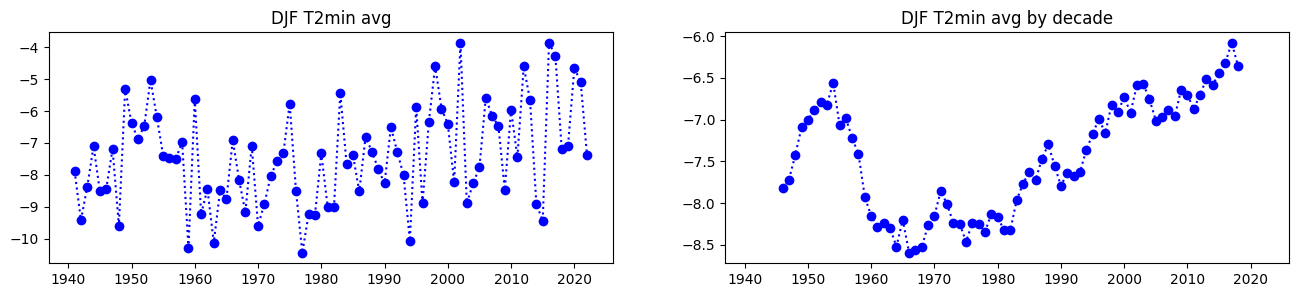

In [7]:
t_trend = df[df.month.isin([12,1,2])].groupby(["year"],as_index=False).agg({'year': 'mean', 't2min_weighted': 'mean'})
t_trend["rolling"] = t_trend["t2min_weighted"].rolling(10,center=True).mean()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].plot(t_trend['year'],t_trend['t2min_weighted'],'o:b')
ax[0].set_title('DJF T2min avg')

ax[1].plot(t_trend['year'],t_trend['rolling'],'o:b')
ax[1].set_title('DJF T2min avg by decade');

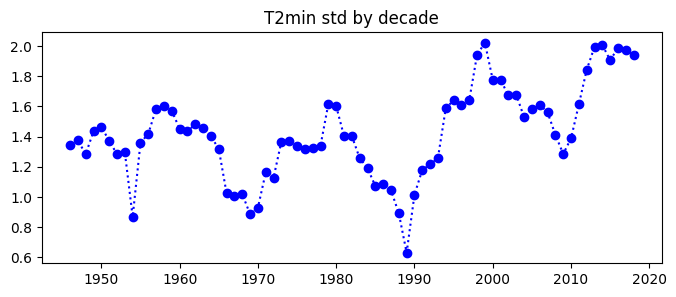

In [8]:
t_trend["rolling"] = t_trend["t2min_weighted"].rolling(10,center=True).std()
plt.figure(figsize=(8, 3))
plt.plot(t_trend['year'],t_trend['rolling'],'o:b')
plt.title('T2min std by decade');
plt.show()

## Strongest CAO of each year

In [9]:
#CAO index
df["cao_index"] = df["tanom_cao"] * df["cao_area_weighted"]
df["cao_index"] = df["cao_index"].fillna(0)

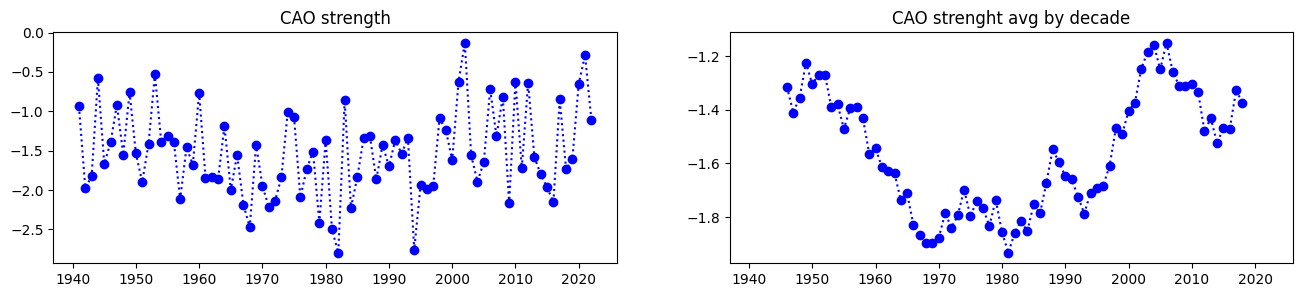

In [10]:
t_trend = df.groupby(["year"],as_index=False).agg({'year': 'mean', 'cao_index': 'min'})
t_trend["rolling"] = t_trend["cao_index"].rolling(10,center=True).mean()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].plot(t_trend['year'],t_trend['cao_index'],'o:b')
ax[0].set_title('CAO strength')

ax[1].plot(t_trend['year'],t_trend['rolling'],'o:b')
ax[1].set_title('CAO strenght avg by decade');
#plt.title('T2min std by decade');

## Strongest CAO + duration (maximum of a 5 day rolling window)

In [11]:
duration = np.zeros(np.shape(t_trend)[0])
idx_peak = np.zeros(np.shape(t_trend)[0])
res_list = list()
for i,cao in enumerate(t_trend.cao_index):
    #ii = np.argwhere(df['cao_index']==cao)
    ii = np.nonzero(df['cao_index']==cao)[0][0]
    selected_data = df['cao_index'].iloc[range(ii-2,ii+3)]
    res_list.append(selected_data.reset_index()['cao_index'])
    idx_peak[i]=ii
    duration[i] = np.sum(selected_data)

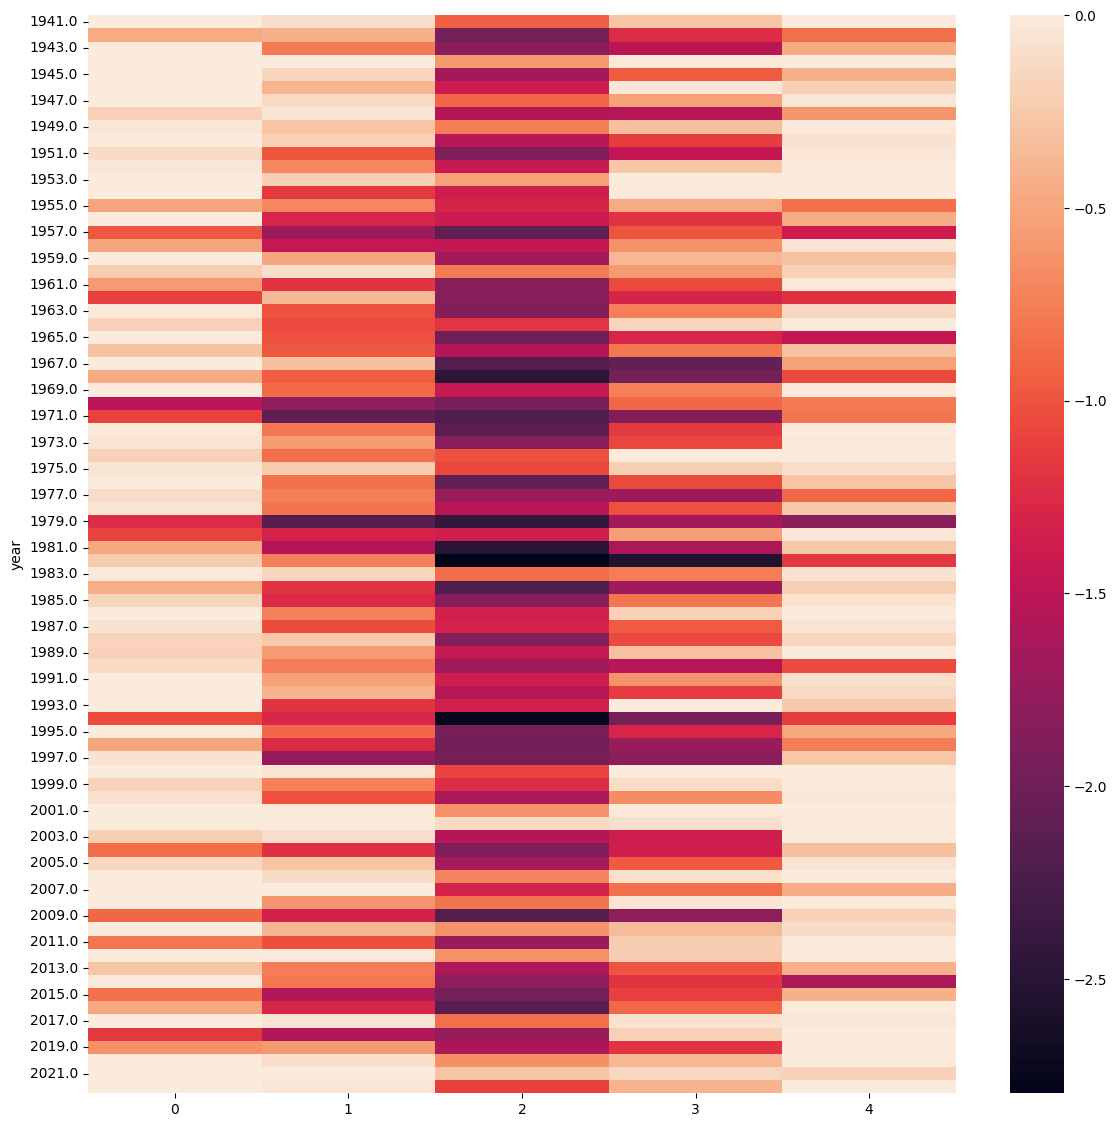

In [12]:
data = pd.DataFrame(res_list)
data.index = t_trend["year"]
plt.figure(figsize=(14, 14))
sns.heatmap(data)
plt.show()

In [13]:
#Select 10 strongest and longest CAO years
persi = pd.DataFrame({"year": t_trend["year"],"rank": np.argsort(duration),"value": duration,"idx": idx_peak})
persi.sort_values("value")#["year"].iloc[range(0,10)]

,year,rank,value,idx
38,1979.0,70,-9.314813,5840.0
53,1994.0,66,-8.183206,8082.0
30,1971.0,44,-8.096903,4623.0
41,1982.0,32,-7.485596,6268.0
16,1957.0,73,-7.188516,2491.0
...,...,...,...,...
12,1953.0,21,-0.755283,1905.0
60,2001.0,45,-0.677803,9173.0
80,2021.0,3,-0.611823,12169.0
3,1944.0,41,-0.605200,563.0


In [14]:
data.to_csv("data/heatmap_data.csv",sep=";")

In [98]:
#cao = np.min(t_trend.cao_index[t_trend['year']==2015])
#ii = np.nonzero(df['cao_index']==cao)[0][0]
#df['cao_index'].iloc[range(ii-3,ii+4)].sort_values()
#np.median(df['cao_index'].iloc[range(ii-3,ii+4)])

In [15]:
t_trend["duration"] = duration

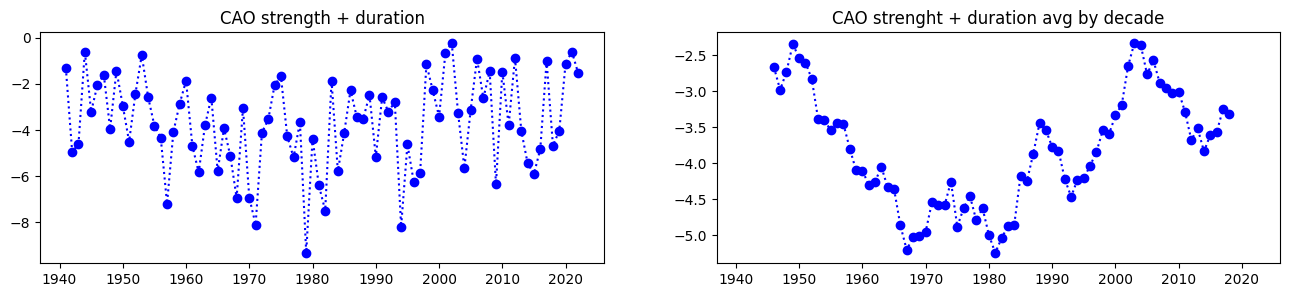

In [16]:
#t_trend = df.groupby(["year"],as_index=False).agg({'year': 'mean', 'duration': lambda x: x.min(skipna=True)})
t_trend["rolling"] = t_trend["duration"].rolling(10,center=True).mean()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].plot(t_trend['year'],t_trend['duration'],'o:b')
ax[0].set_title('CAO strength + duration')

ax[1].plot(t_trend['year'],t_trend['rolling'],'o:b')
ax[1].set_title('CAO strenght + duration avg by decade');
#plt.title('T2min std by decade');

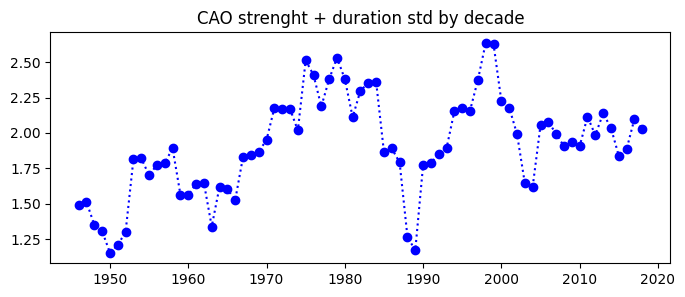

In [17]:
t_trend["rolling"] = t_trend["duration"].rolling(10,center=True).std()
plt.figure(figsize=(8, 3))
plt.plot(t_trend['year'],t_trend['rolling'],'o:b')
plt.title('CAO strenght + duration std by decade');
plt.show()

In [ ]:
t_trend.sort_values("cao_index").head(10)

,year,cao_index,rolling,duration
41,1982.0,-2.796601,2.299325,-7.485596
53,1994.0,-2.758798,2.154790,-8.183206
40,1981.0,-2.500604,2.111121,-6.400949
27,1968.0,-2.472791,1.847178,-6.940595
38,1979.0,-2.415553,2.531857,-9.314813
43,1984.0,-2.224453,2.360381,-5.780334
30,1971.0,-2.215044,2.176175,-8.096903
26,1967.0,-2.187700,1.831809,-5.117843
68,2009.0,-2.170385,1.935329,-6.359069
75,2016.0,-2.155603,1.885874,-4.824314


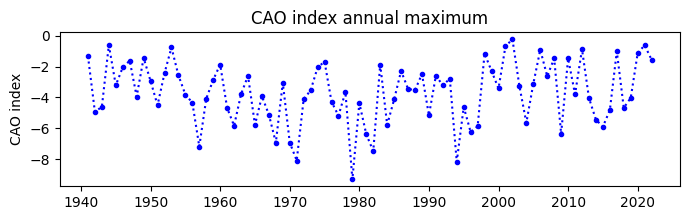

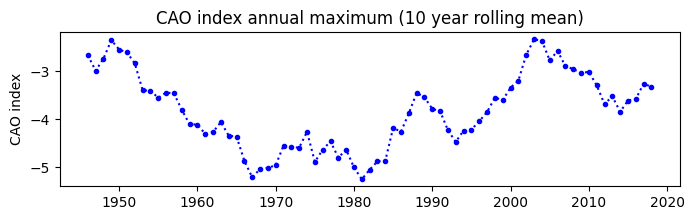

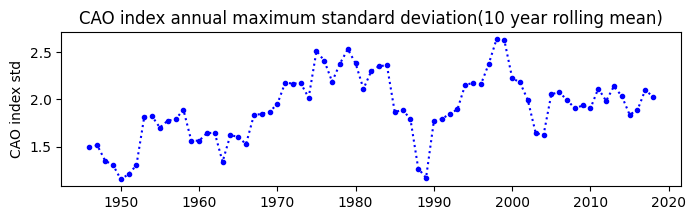

In [102]:
#Saving images
#t_trend = df.groupby(["year"],as_index=False).agg({'year': 'mean', 'duration': lambda x: x.min(skipna=True)})
#t_trend['duration'] = -t_trend['duration']
t_trend["rolling_min"] = t_trend["duration"].rolling(10,center=True).mean()
t_trend["rolling_std"] = t_trend["duration"].rolling(10,center=True).std()

plt.figure(figsize=(8, 2))
plt.plot(t_trend['year'],t_trend['duration'],'o:b',markersize=3)
plt.title('CAO index annual maximum')
plt.ylabel('CAO index')
plt.savefig("{}/{}.png".format("figures","cao_index_annual"))

plt.figure(figsize=(8, 2))
plt.plot(t_trend['year'],t_trend['rolling_min'],'o:b',markersize=3)
plt.title('CAO index annual maximum (10 year rolling mean)')
plt.ylabel('CAO index')
plt.savefig("{}/{}.png".format("figures","cao_index_annual_rol"))

plt.figure(figsize=(8, 2))
plt.plot(t_trend['year'],t_trend['rolling_std'],'o:b',markersize=3)
plt.title('CAO index annual maximum standard deviation(10 year rolling mean)')
plt.ylabel('CAO index std')
plt.savefig("{}/{}.png".format("figures","cao_index_annual_rol_std"))


#fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

#ax[0].plot(t_trend['year'],t_trend['duration'],'o:b')
#ax[0].set_title('CAO strength + duration')

#ax[1].plot(t_trend['year'],t_trend['rolling'],'o:b')
#ax[1].set_title('CAO strenght + duration avg by decade');

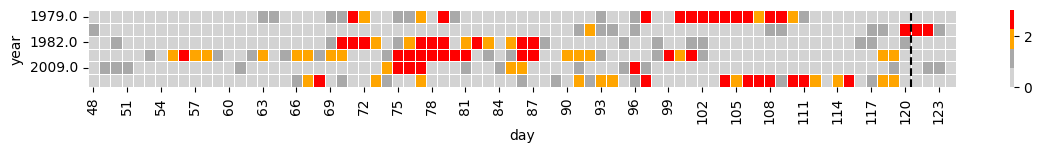

In [103]:
data = df[df.year.isin([1980,1979,1982,1994,2009,2015])].pivot(columns='day',values='class_to_numeric',index='year')

plt.figure(figsize=(14, 1))
sns.heatmap(data, 
                cmap=sns.color_palette(list(class_colors.values()), as_cmap=True),

linewidths=.5)
plt.yticks(fontsize=10)  
plt.axvline(31,color='black',linestyle='--')
plt.axvline(121,color='black',linestyle='--')
plt.xlim(48,125)
plt.show()

In [104]:
t_trend.sort_values("duration").to_csv("data/cao_rank_annually.csv",sep=";",index=False)

# cold event \< 10% (similar to Cohen 2023)

In [105]:
df.head(1)

,time,cao_area_simple,cao_area_weighted,cao_area_gaussian,t2min_cao,tanom_cao,tanom_mean,tanom_mean_weighted,t2min,t2min_weighted,...,t2min_min,t2min_q05,year,class,class_to_numeric,month,day,group,decade,cao_index
305,1940-11-01,0.0,0.0,0.0,NaN,NaN,0.48077,1.649267,2.874725,3.262868,...,-14.18692,-282.213275,1941.0,no_cao,0,11,0,1,1940,0.0


In [106]:
df["q10"] = df[df.month.isin([12,1,2])]['t2min_weighted'].quantile(.05)
df["condition"] = df["t2min_weighted"] < df["q10"]
N = df.groupby(["year"],as_index=False).agg({'year': 'mean', 'condition': 'sum','decade': 'mean'})
N

,year,condition,decade
0,1941.0,0,1940.0
1,1942.0,7,1940.0
2,1943.0,6,1940.0
3,1944.0,0,1940.0
4,1945.0,3,1940.0
...,...,...,...
77,2018.0,7,2010.0
78,2019.0,3,2010.0
79,2020.0,0,2020.0
80,2021.0,0,2020.0


In [107]:
#N_colors = len(df['decade'].unique())
#color_list = list()
#for i in range(0,N_colors):
#    color = random.randrange(0, 2**24)
#    hex_color = hex(color)
#    std_color = "#" + hex_color[2:]
#    color_list.append(std_color)

In [108]:
color_list = ['#48d0ca',
 '#5c9649',
 '#d3f902',
 '#a3e782',
 '#2de4bd',
 '#8a1ce2',
 '#a5af11',
 '#afa2cb',
 '#7b304f']

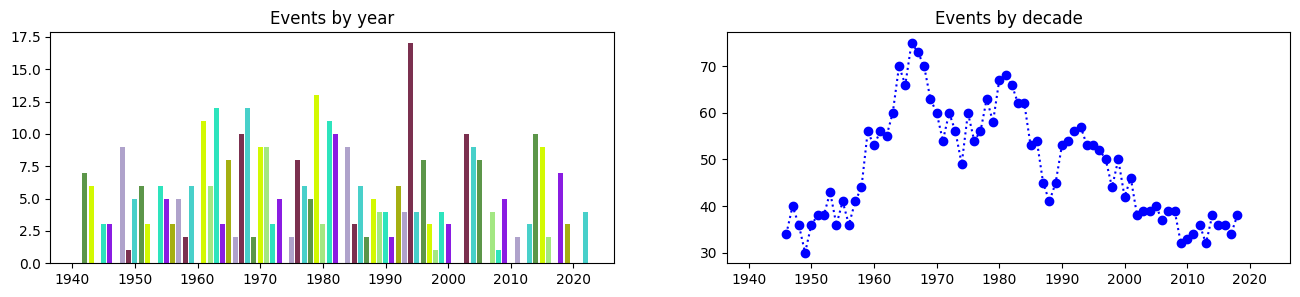

In [109]:
t_trend_dec = N
t_trend_dec["rolling"] = N["condition"].rolling(10,center=True).sum()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].bar(t_trend_dec['year'],t_trend_dec['condition'],color=color_list)
ax[0].set_title('Events by year')
#ax[0].set_xlim(1960,2022)

ax[1].plot(t_trend_dec['year'],t_trend_dec['rolling'],'o:b')
ax[1].set_title('Events by decade');

In [110]:
decades = t_trend_dec["decade"].unique()
n_decades = np.size(t_trend_dec["decade"].unique())
d_list = np.ones(n_decades)
for i,d in enumerate(decades):
    d_list[i] = ((np.argwhere(t_trend_dec["decade"]==d))[0])

/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1162/234922896.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_list[i] = ((np.argwhere(t_trend_dec["decade"]==d))[0])


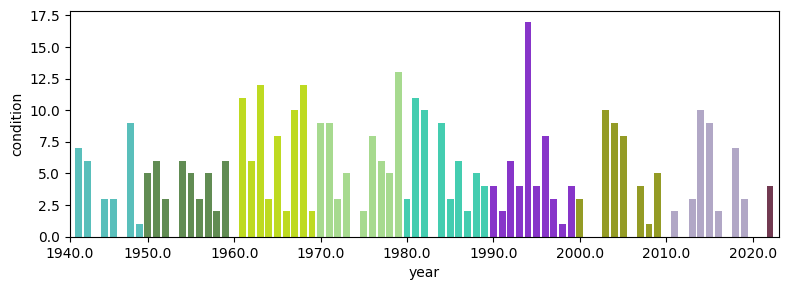

In [111]:
idx_i = np.argwhere(t_trend_dec["year"]==1960)[0]
idx_e = np.argwhere(t_trend_dec["year"]==2022)[0]

plt.figure(figsize=(8,3))
ax=sns.barplot(x='year', y='condition', data=t_trend_dec, hue='decade', dodge=False,palette=color_list,legend=False)
#ax.set_xticklabels([''])
ax.set_xlim(idx_i,idx_e+1)
#ax.set_xticks(ticks=np.arange(0, 365, 30), labels=np.arange(0, 365, 30))
ax.set_xticks(ticks=d_list, labels=decades)
#ax.set_yscale('log')
#ax.set_title('SE Africa')
plt.tight_layout()
plt.show()

In [112]:
ax.get_xbound()

(np.float64(0.0), np.float64(82.0))

# GEV

In [113]:
t_trend

,year,cao_index,rolling,duration,rolling_min,rolling_std
0,1941.0,-0.937236,NaN,-1.311599,NaN,NaN
1,1942.0,-1.972937,NaN,-4.949723,NaN,NaN
2,1943.0,-1.827657,NaN,-4.601199,NaN,NaN
3,1944.0,-0.581237,NaN,-0.605200,NaN,NaN
4,1945.0,-1.667457,NaN,-3.209326,NaN,NaN
...,...,...,...,...,...,...
77,2018.0,-1.737300,2.02528,-4.674154,-3.322071,2.02528
78,2019.0,-1.605651,NaN,-4.035990,NaN,NaN
79,2020.0,-0.651283,NaN,-1.123277,NaN,NaN
80,2021.0,-0.284702,NaN,-0.611823,NaN,NaN


In [114]:
#t_trend = df.groupby(["year"],as_index=False).agg({'year': 'mean', 'duration': lambda x: x.min(skipna=True)})
#t_trend["rolling"] = t_trend["duration"].rolling(10,center=True).mean()

#t_trend['rank'] = t_trend['duration'].rank()
#t_trend = t_trend.sort_values('rank',ascending=False)
N=t_trend.shape[0]
i = np.linspace(1,N,N)
p = i/(N+1)
xp = 1 - p


In [115]:
def fun(params,tides):
    F = lambda x: genextreme.cdf(x,*params)
    result = -sum([np.log(d) for d in np.diff([0]+[F(_) for _ in tides]+[1])])
    return result

shape = 0.5
location = 234
scale = 50
x0 = (shape, location, scale)

result = minimize(fun, x0, args=-t_trend['duration'], method='Nelder-Mead')

/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1162/664042676.py:3: RuntimeWarning: invalid value encountered in log
  result = -sum([np.log(d) for d in np.diff([0]+[F(_) for _ in tides]+[1])])


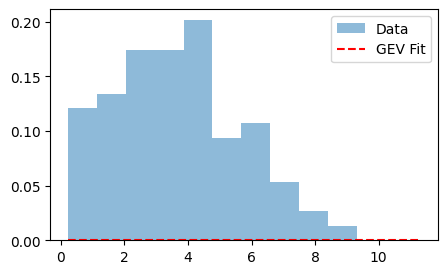

In [116]:
x = np.linspace(np.min(-t_trend['duration']),np.max(-t_trend['duration'])+2,1000)

f = lambda x: genextreme.pdf(x,*result.x)
gev = [f(_) for _ in x]
plt.figure(figsize=(5, 3))
plt.hist(-t_trend['duration'], density=True, alpha=0.5, label='Data')
plt.plot(x, gev, 'r--', label='GEV Fit')
plt.legend(loc='upper right')
plt.show()

In [117]:
x = np.linspace(np.min(-t_trend['duration']),np.max(-t_trend['duration'])+2,1000)
f = lambda x: genextreme.pdf(x,*result.x)
gev = [f(_) for _ in x]
return_periods = np.linspace(2,500,500)
#return_levels = np.quantile(gev, 1 - (1 / return_periods))
return_levels = genextreme.ppf(1 - (1 / return_periods),*result.x)
#genextreme.ppf(.99,*result.x)

In [118]:
n_boot = 1000
gev_boot = [genextreme.rvs(*result.x) for i in range(0,n_boot*N)]
gev_boot = np.array(gev_boot).reshape((N, n_boot))

In [119]:
gev_q99 = np.apply_along_axis(np.quantile, axis=0, arr=gev_boot,q=.99)
up,low = np.quantile(gev_q99,[.975,0.025])

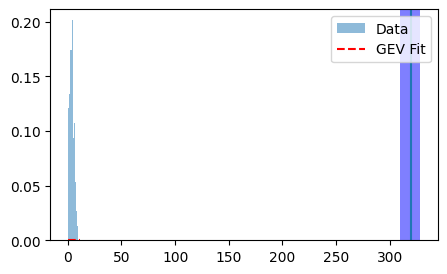

In [120]:
#plt.hist(-t_trend['duration'])


plt.figure(figsize=(5, 3))
plt.hist(-t_trend['duration'], density=True, alpha=0.5, label='Data')
plt.plot(x, gev, 'r--', label='GEV Fit')
plt.axvspan(low, up, facecolor='b', alpha=0.5)
plt.axvline(np.mean(gev_q99))
plt.legend(loc='upper right')
plt.show()

In [121]:
#np.apply_along_axis(np.quantile, axis=1, arr=gev_boot,q=[.975,0.025])

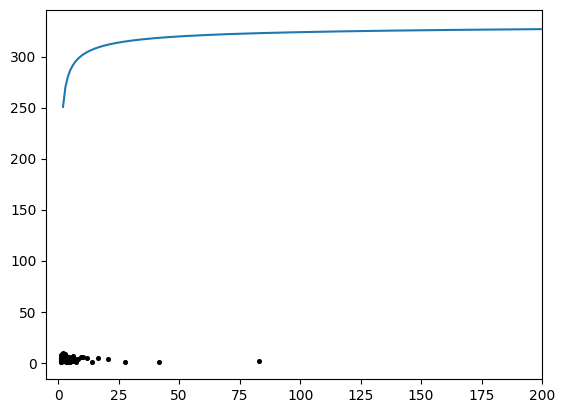

In [122]:
plt.plot(return_periods, return_levels)
plt.scatter(1/xp,-t_trend['duration'],s=7,color="black")
plt.xlim(-5,200)

full_return_periods = return_periods
full_return_levels = return_levels

# Periods selection impact in GEV

In [123]:
def neg_log_likelihood(params,data):
    F = lambda x: genextreme.logpdf(x,*params)
    result = -sum(F(_) for _ in data)
    return result

#Using parametric bootstrap for parameter error estimation
def bootstrap_covar(xi,mu,sigma,obs,n_bootstrap=1000):
    N = len(obs)
    bootstrap_params = np.zeros((n_bootstrap, 3))
    for i in range(n_bootstrap):
        synthetic_data = genextreme.rvs(xi, loc=mu, scale=sigma, size=N)
        #result = minimize(neg_log_likelihood, initial_guess, args=(synthetic_data,), 
        #                     method='Nelder-Mead')
        #bootstrap_params[i] = result.x
        result = genextreme.fit(synthetic_data)
        bootstrap_params[i] = np.array([result[1],result[2],-result[0]]) #order like in the extreme book

    vcov_matrix = np.cov(bootstrap_params, rowvar=False)
    return vcov_matrix #variance-covariance matrix, variances of each parameter in the main diagonal

def return_interval(mu,sigma,xi,p):
    y = -np.log(1-p)
    z = mu - sigma/xi * (1 - (y)**(-xi))
    return z

def return_interval_std(sigma,xi,p,vcov_matrix):
    y = -np.log(1-p)
    vcov_zp = np.array([1,-(1/xi)*(1-(y)**(-xi)),sigma * xi**(-2)*(1-(y)**(-xi))- sigma* (xi**(-1))* (y**(-xi)) *np.log(y)])
    var_z = np.matmul(np.matmul(vcov_zp.T, vcov_matrix),vcov_zp)
    std_z = np.sqrt(var_z)
    return std_z


In [124]:
#observations
VAR = 'duration'
#t_trend = df.groupby(["year"],as_index=False).agg({'group': 'min','year': 'mean', VAR: lambda x: x.min(skipna=True)})
if(VAR=='duration'):
    t_trend[VAR] = -t_trend[VAR]

t_trend = t_trend.sort_values(VAR)

obs_rank = t_trend[VAR]
obs_rank = obs_rank
p_obs = np.ones(N)
for i in range(N): 
    p_obs[i] = ((i+1)/(N+1))

obs_return = 1/(1-p_obs)

obs = t_trend[VAR]

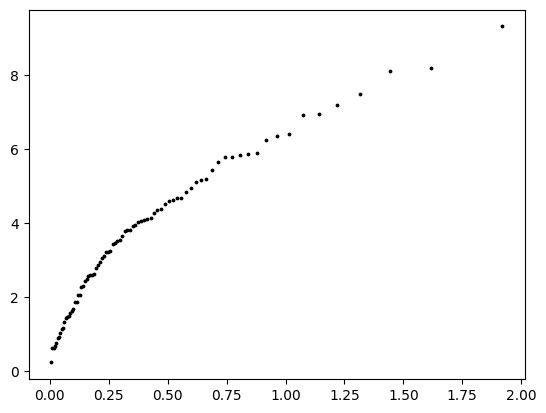

In [125]:
plt.scatter(np.log10(obs_return),obs_rank,s=3,color="black")

In [126]:
p = np.linspace(0,1,1000)
p = p[1:]

gev_params = genextreme.fit(obs)
xi = -gev_params[0]
mu = gev_params[1]
sigma = gev_params[2]
print(mu,sigma,xi)

vcov_matrix = bootstrap_covar(xi,mu,sigma,obs,n_bootstrap=1000)

z_p = np.array([return_interval(mu,sigma,xi,_) for _ in p])
z_p_std = np.array([return_interval_std(sigma,xi,_,vcov_matrix) for _ in p])
lower_bound = z_p - 1.96*z_p_std
upper_bound = z_p + 1.96*z_p_std

2.8433993837975553 1.780984895942351 -0.12271049433775152


/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1162/2585422975.py:22: RuntimeWarning: divide by zero encountered in log
  y = -np.log(1-p)
/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1162/2585422975.py:27: RuntimeWarning: divide by zero encountered in log
  y = -np.log(1-p)
/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1162/2585422975.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  vcov_zp = np.array([1,-(1/xi)*(1-(y)**(-xi)),sigma * xi**(-2)*(1-(y)**(-xi))- sigma* (xi**(-1))* (y**(-xi)) *np.log(y)])


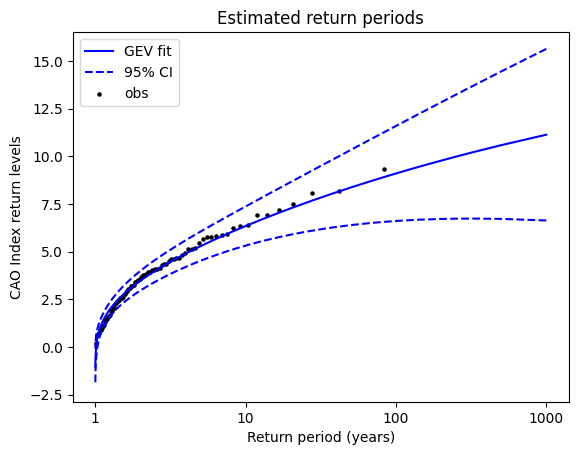

In [127]:
#plt.figure(figsize=(8, 2))
fig, ax = plt.subplots()
plt.plot(np.log10(1/p),z_p,label='GEV fit',color='blue')
plt.plot(np.log10(1/p),lower_bound,linestyle="--",color='blue',label = "95% CI")
plt.plot(np.log10(1/p),upper_bound,linestyle="--",color='blue')
plt.scatter(np.log10(obs_return),obs_rank,s=5,color="black",label="obs")
plt.title('Estimated return periods')
plt.legend()
plt.ylabel("CAO Index return levels")
plt.xlabel("Return period (years)")
#x axis labels
ax.set_xticks(np.array([0,1,2,3]), labels=[1,10,100,1000])
plt.savefig("{}/{}.png".format("figures","GEV_fit_full_period"))

1


/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1162/2585422975.py:22: RuntimeWarning: divide by zero encountered in log
  y = -np.log(1-p)


KeyError: 'group'

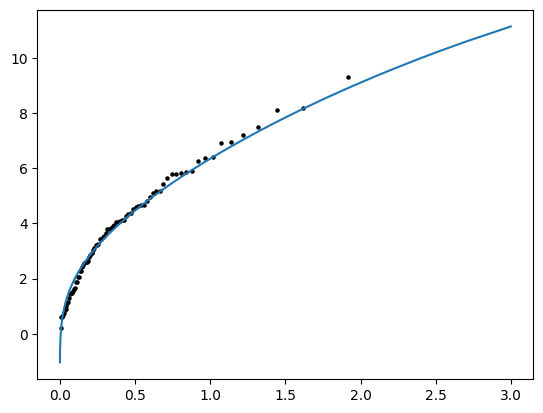

In [128]:
fig, ax = plt.subplots()
plt.scatter(np.log10(obs_return),obs_rank,s=5,color="black")
#plt.xlim(-5,200)
param_list = list()
VAR = 'duration'
groups = np.array([0,1,2])
labels = ["Full","pre 1979","pos 1979"]
p = np.linspace(0,1,1000)
p = p[1:]
for g in groups:
    if(g!=0):
        print(g)
        df_gev = t_trend[t_trend['group']==g]
    else:
        df_gev = t_trend
    obs = df_gev[VAR]
    gev_params = genextreme.fit(obs)
    xi = -gev_params[0]
    mu = gev_params[1]
    sigma = gev_params[2]
    z_p = np.array([return_interval(mu,sigma,xi,_) for _ in p])
    plt.plot(np.log10(1/p),z_p,label=labels[g])
plt.legend()
plt.ylabel("CAO Index")
plt.xlabel("Return period (years)")
#x axis labels
ax.set_xticks(np.array([0,1,2,3]), labels=[1,10,100,1000])
plt.show()

#Group 0 (Full Period)
#Group 1 (before 1979)
#Group 2 (after 1979)

# older version of the GEV below

In [ ]:
t_trend = df.groupby(["year"],as_index=False).agg({'group': 'min','year': 'mean', 'duration': lambda x: x.min(skipna=True)})

VAR = 'duration'
df_gev = t_trend
df_gev = df_gev.sort_values(VAR,ascending=False)

def GEV_MLE(params,data):
    F = lambda x: genextreme.cdf(x,*params)
    result = -sum([np.log(d) for d in np.diff([0]+[F(_) for _ in data]+[1])])
    return result

shape = 0.5
location = 234
scale = 50
x0 = (shape, location, scale)

gev_params = minimize(GEV_MLE, x0, args=-df_gev[VAR], method='Nelder-Mead')

/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1028/2461195704.py:9: RuntimeWarning: divide by zero encountered in log
  result = -sum([np.log(d) for d in np.diff([0]+[F(_) for _ in data]+[1])])


In [ ]:
print('GEV parameters')
print(gev_params.x)

GEV parameters
[0.12077415 0.62146438 0.4516884 ]


(-5.0, 200.0)

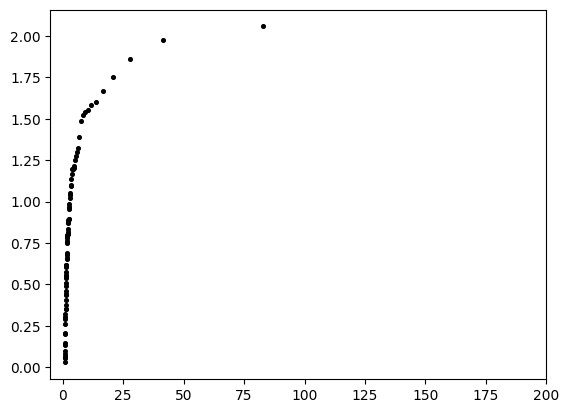

In [ ]:
x = np.linspace(np.min(-df_gev[VAR]),np.max(-df_gev[VAR])+2,1000)
f = lambda x: genextreme.pdf(x,*gev_params.x)
gev_pdf = [f(_) for _ in x]
return_periods = np.linspace(2,500,500)
return_levels = genextreme.ppf(1 - (1 / return_periods),*result.x)

plt.scatter(1/xp,-df_gev[VAR],s=7,color="black")
plt.xlim(-5,200)

/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1028/664042676.py:3: RuntimeWarning: divide by zero encountered in log
  result = -sum([np.log(d) for d in np.diff([0]+[F(_) for _ in tides]+[1])])


[0.10340515 0.63875771 0.38290553]
[0.11539131 0.6007358  0.52355246]


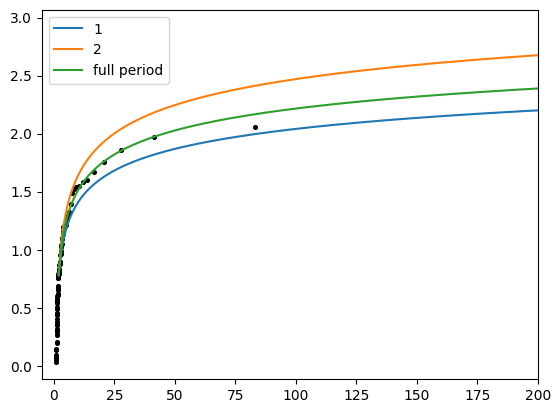

In [ ]:
t_trend = df.groupby(["year"],as_index=False).agg({'group': 'min','year': 'mean', 'duration': lambda x: x.min(skipna=True)})

VAR = 'duration'
df_gev = t_trend
df_gev = df_gev.sort_values(VAR,ascending=False)

plt.scatter(1/xp,-df_gev[VAR],s=7,color="black")
plt.xlim(-5,200)
param_list = list()
VAR = 'duration'
for g in t_trend['group'].unique():
    df_gev = t_trend[t_trend['group']==g]
    df_gev = df_gev.sort_values(VAR,ascending=False)
    shape = 0.5
    location = 234
    scale = 50
    x0 = (shape, location, scale)
    gev_params = minimize(fun, x0, args=-df_gev['duration'], method='Nelder-Mead')
    print(gev_params.x)
    x = np.linspace(np.min(-df_gev[VAR]),np.max(-df_gev[VAR])+2,1000)
    f = lambda x: genextreme.pdf(x,*gev_params.x)
    gev_pdf = [f(_) for _ in x]
    return_periods = np.linspace(2,500,500)
    return_levels = genextreme.ppf(1 - (1 / return_periods),*gev_params.x)
    param_list.append(np.array(gev_params.x))
    plt.plot(return_periods, return_levels,label=g)
plt.plot(full_return_periods, full_return_levels,label="full period")
plt.legend()
plt.show()

#Group 1 (before 1979)
#Group 2 (after 1979)

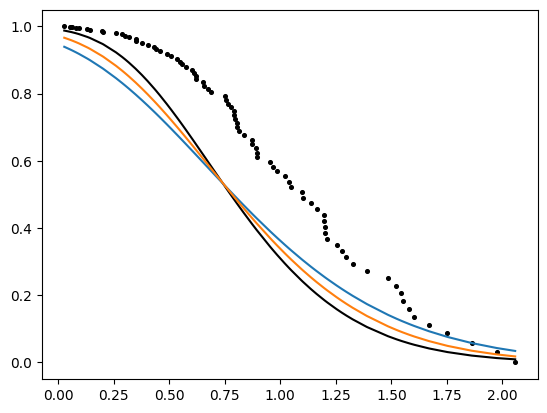

In [ ]:
gev_surv_0 = 1-genextreme.cdf(-df_gev[VAR],*param_list[0])
gev_surv_1 = 1-genextreme.cdf(-df_gev[VAR],*param_list[1])
gev_surv_2 =  1-genextreme.cdf(-df_gev[VAR],*gev_params.x)
plt.plot(-df_gev[VAR],gev_surv_0,color="black")
plt.plot(-df_gev[VAR],gev_surv_1)
plt.plot(-df_gev[VAR],gev_surv_2)
plt.scatter(-df_gev[VAR],1-((-df_gev[VAR]).cumsum())/np.max(-df_gev[VAR].cumsum()),s=7,color="black")


In [ ]:
#sample observed values from the GEV CDF
#Survival plot

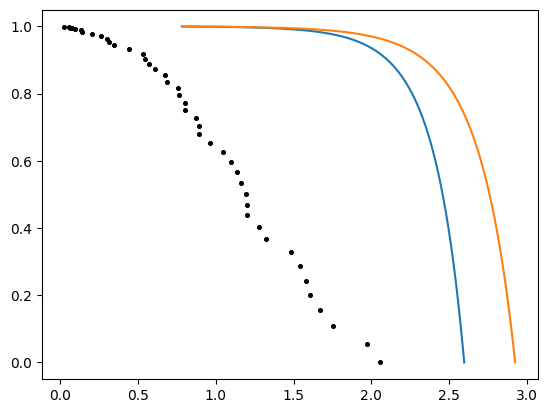

In [ ]:
#survival plot
p = full_return_levels.cumsum()/np.max(full_return_levels.cumsum())
plt.plot(full_return_levels, 1-p,label="full period")
plt.plot(return_levels, 1-return_levels.cumsum()/np.max(return_levels.cumsum()),label=g)


plt.scatter(-df_gev[VAR],1-((-df_gev[VAR]).cumsum())/np.max(-df_gev[VAR].cumsum()),s=7,color="black")


In [ ]:
np.max(p)

np.float64(2.357719714675582)

In [ ]:
result.x

array([0.12077415, 0.62146438, 0.4516884 ])

In [ ]:
np.array([0.12077415, 0.62146438 ,0.4516884 ])

array([0.12077415, 0.62146438, 0.4516884 ])

In [ ]:
#gev_1 = genextreme.ppf(1 - (1 / return_periods),[0.12077415, 0.62146438 ,0.4516884 ]) #genextreme.pdf(9,[0.12077415, 0.62146438 ,0.4516884 ])
x=1 - (1 / return_periods)
params = np.array([0.12077415, 0.62146438 ,0.4516884 ])
f = lambda x: genextreme.pdf(x,*params)
gev_1 = [f(_) for _ in x]
params = np.array([0.10340515, 0.63875771, 0.38290553])
gev_2 = [f(_) for _ in x]
params = np.array([0.11539131, 0.6007358,  0.52355246])
gev_3 = [f(_) for _ in x]

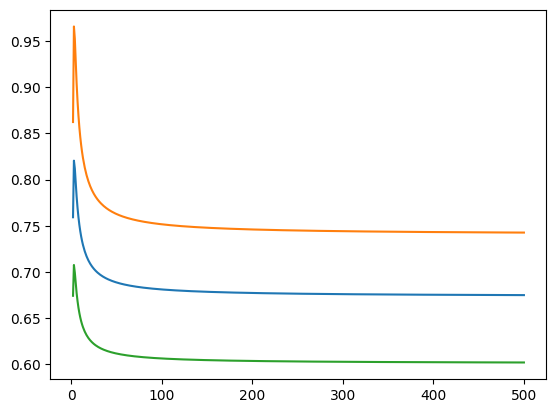

In [ ]:
plt.plot(return_periods,gev_1)
plt.plot(return_periods,gev_2)
plt.plot(return_periods,gev_3)

In [ ]:
t_trend = df_gev.sort_values(VAR,ascending=False)
N=t_trend.shape[0]
i = np.linspace(1,N,N)
p = i/(N+1)
xp = 1 - p

x = np.linspace(np.min(-t_trend['duration']),np.max(-t_trend['duration'])+2,1000)

f = lambda x: genextreme.pdf(x,*result.x)
gev_pdf = [f(_) for _ in x]
plt.figure(figsize=(5, 3))
plt.hist(-t_trend['duration'], density=True, alpha=0.5, label='Data')
plt.plot(x, gev, 'r--', label='GEV Fit')
plt.legend(loc='upper right')
plt.show()

x = np.linspace(np.min(-t_trend['duration']),np.max(-t_trend['duration'])+2,1000)
f = lambda x: genextreme.pdf(x,*result.x)
gev = [f(_) for _ in x]
return_periods = np.linspace(2,500,500)
#return_levels = np.quantile(gev, 1 - (1 / return_periods))
return_levels = genextreme.ppf(1 - (1 / return_periods),*result.x)
#genextreme.ppf(.99,*result.x)

x = np.linspace(np.min(-t_trend['duration']),np.max(-t_trend['duration'])+2,1000)
f = lambda x: genextreme.pdf(x,*result.x)
gev = [f(_) for _ in x]
return_periods = np.linspace(2,500,500)
#return_levels = np.quantile(gev, 1 - (1 / return_periods))
return_levels = genextreme.ppf(1 - (1 / return_periods),*result.x)
#genextreme.ppf(.99,*result.x)

n_boot = 1000
gev_boot = [genextreme.rvs(*result.x) for i in range(0,n_boot*N)]
gev_boot = np.array(gev_boot).reshape((N, n_boot))

gev_q99 = np.apply_along_axis(np.quantile, axis=0, arr=gev_boot,q=.99)
up,low = np.quantile(gev_q99,[.975,0.025])

In [ ]:
fit_values, a, b = fit_ols(x=df_reg[['year']],y=df_reg[VAR])
fit_values_2, a_2, b_2 = fit_ols(x=df_reg[df_reg.year>=1979][['year']],y=df_reg[df_reg.year>=1979][VAR])
fit_values_3, a_3, b_3 = fit_ols(x=df_reg[df_reg.year<1979][['year']],y=df_reg[df_reg.year<1979][VAR])

# Trend

In [ ]:
def fit_ols(y,x):
    x = sm.add_constant(x, prepend=False)
    y = y.values.reshape(-1,1)
    model = sm.OLS(y,x).fit()
    fit_values = model.fittedvalues
    a, b = model.params
    return fit_values, a, b

In [ ]:
VAR = 'tanom_cao'

df_reg = df[df.month.isin([12,1,2])].groupby(["year"],as_index=False).agg({'year': 'mean', VAR: 'min'})

In [ ]:
fit_values, a, b = fit_ols(x=df_reg[['year']],y=df_reg[VAR])
fit_values_2, a_2, b_2 = fit_ols(x=df_reg[df_reg.year>=1979][['year']],y=df_reg[df_reg.year>=1979][VAR])
fit_values_3, a_3, b_3 = fit_ols(x=df_reg[df_reg.year<1979][['year']],y=df_reg[df_reg.year<1979][VAR])

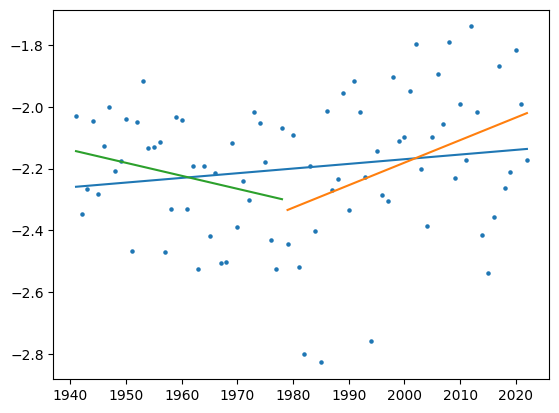

In [ ]:
plt.scatter(df_reg[['year']],df_reg[VAR],s=5)
plt.plot(df_reg[['year']],fit_values)
plt.plot(df_reg[df_reg.year>=1979][['year']],fit_values_2)
plt.plot(df_reg[df_reg.year<1979][['year']],fit_values_3)

----

In [ ]:
res = df_to_reg['cao_count']-fit_values
res_std = np.std(res)
N = 10000
y_projection = np.ones((len(years_future),N))
for i,y in enumerate(years_future):
    y_projection[i,:] = np.random.normal(a*y+b,res_std,N)
#bootstrap N samples from linear regression

mean_values = list(map(np.mean,y_projection))
std_values = list(map(np.std,y_projection))
mean_ci = [(1.96*arr)/(np.sqrt(N)) for arr in std_values]
upper = [np.quantile(arr, .975) for arr in y_projection]
lower = [np.quantile(arr, .025) for arr in y_projection]

plt.plot(years_future,mean_values,color='black')
plt.plot(years_future,upper,color='blue')
plt.plot(years_future,lower,color='blue')
plt.scatter(df_to_reg.year,df_to_reg['cao_count'],s=3,color='black')
plt.fill_between(x=years_future,y1=lower,y2=mean_values,alpha=0.2,color='blue')
plt.fill_between(x=years_future,y1=mean_values,y2=upper,alpha=0.2,color='blue')
plt.ylabel("CAO days/year")
#plt.xlim(1940,2200)
plt.axhline(0,color='black',linestyle='--')

In [ ]:
cao_by_year = df.groupby(["year","class"],as_index=False).agg({'year': 'mean', 'time': 'count'})
cao_by_year

,class,year,time
0,moderate,1941.0,4
1,no_cao,1941.0,135
2,weak,1941.0,12
3,moderate,1942.0,5
4,no_cao,1942.0,125
...,...,...,...
301,weak,2021.0,2
302,moderate,2022.0,6
303,no_cao,2022.0,133
304,strong,2022.0,2


In [ ]:
cao_by_year = cao_by_year.pivot_table(columns='class',values='time',index='year',fill_value=0)
cao_by_year.head(1)

class,moderate,no_cao,strong,weak
year,,,,
1941.0,4.0,135.0,0.0,12.0


In [ ]:
#seaborn plots
#sns.displot(data=t_trend, x="cao_index",kde=True)
#sns.displot(data=df[df["class"]=="strong"], x="tanom_cao", hue="group", kind='kde')
#sns.displot(data=df[df["class"]=="strong"], x="cao_area_weighted", hue="group",kind='kde')
#g = sns.displot(data=df[df["class"]=="strong"], y="cao_area_weighted", x="tanom_cao", kind='kde')
#sns.displot(data=df[(df["class"]=="strong")&(df["decade"]!=2020)], x="tanom_cao", hue="decade", kind="kde",col="decade")
#sns.displot(data=cao_by_year, x="time", kind="kde")


#g = sns.FacetGrid(df, col="class", height=2.5, col_wrap=2)
#g.map(sns.histplot, "time")

In [ ]:
year = cao_by_year.index
cao_count = (cao_by_year['moderate'] + cao_by_year['strong']).values
df_to_reg = pd.DataFrame({'year': year, 'cao_count': cao_count})
#prepare data to fit

df_to_reg = sm.add_constant(df_to_reg, prepend=False)
#add constant for intercept fit

In [ ]:
df_to_reg = df_to_reg[df_to_reg.year>1978]

In [ ]:
def fit_ols(y,x):
    x = sm.add_constant(x, prepend=False)
    y = y.values.reshape(-1,1)
    model = sm.OLS(y,x).fit()
    fit_values = model.fittedvalues
    a, b = model.params
    return fit_values, a, b

fit_values, a, b = fit_ols(x=df_to_reg[['year']],y=df_to_reg['cao_count'])
res = df_to_reg['cao_count']-fit_values
res_std = np.std(res)
N = 10000
y_projection = np.ones((len(years_future),N))
for i,y in enumerate(years_future):
    y_projection[i,:] = np.random.normal(a*y+b,res_std,N)
#bootstrap N samples from linear regression

mean_values = list(map(np.mean,y_projection))
std_values = list(map(np.std,y_projection))
mean_ci = [(1.96*arr)/(np.sqrt(N)) for arr in std_values]
upper = [np.quantile(arr, .975) for arr in y_projection]
lower = [np.quantile(arr, .025) for arr in y_projection]

plt.plot(years_future,mean_values,color='black')
plt.plot(years_future,upper,color='blue')
plt.plot(years_future,lower,color='blue')
plt.scatter(df_to_reg.year,df_to_reg['cao_count'],s=3,color='black')
plt.fill_between(x=years_future,y1=lower,y2=mean_values,alpha=0.2,color='blue')
plt.fill_between(x=years_future,y1=mean_values,y2=upper,alpha=0.2,color='blue')
plt.ylabel("CAO days/year")
#plt.xlim(1940,2200)
plt.axhline(0,color='black',linestyle='--')

In [ ]:
fit_values, a, b = fit_ols(x=df_to_reg[['year']],y=df_to_reg['cao_count'])

In [ ]:
res = df_to_reg['cao_count']-fit_values
res_std = np.std(res)

In [ ]:
years_future = list(range(1900,2300,1))
#model projections

In [ ]:
N = 10000
y_projection = np.ones((len(years_future),N))
for i,y in enumerate(years_future):
    y_projection[i,:] = np.random.normal(a*y+b,res_std,N)
#bootstrap N samples from linear regression

mean_values = list(map(np.mean,y_projection))
std_values = list(map(np.std,y_projection))
mean_ci = [(1.96*arr)/(np.sqrt(N)) for arr in std_values]
upper = [np.quantile(arr, .975) for arr in y_projection]
lower = [np.quantile(arr, .025) for arr in y_projection]

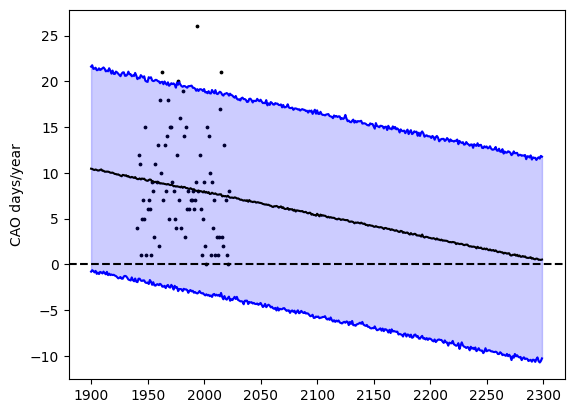

In [ ]:
plt.plot(years_future,mean_values,color='black')
plt.plot(years_future,upper,color='blue')
plt.plot(years_future,lower,color='blue')
plt.scatter(df_to_reg.year,df_to_reg['cao_count'],s=3,color='black')
plt.fill_between(x=years_future,y1=lower,y2=mean_values,alpha=0.2,color='blue')
plt.fill_between(x=years_future,y1=mean_values,y2=upper,alpha=0.2,color='blue')
plt.ylabel("CAO days/year")
#plt.xlim(1940,2200)
plt.axhline(0,color='black',linestyle='--')

In [ ]:
df.head(1)

,time,cao_area_simple,cao_area_weighted,cao_area_gaussian,t2min_cao,tanom_cao,tanom_mean,tanom_mean_weighted,t2min,t2min_weighted,t2min_gaussian,t2min_min,t2min_q05,year,class,class_to_numeric,month,decade,day,cao_index
305,1940-11-01,0.0,0.0,0.0,NaN,NaN,0.48077,1.649267,2.874725,3.262868,-270.24797,-14.18692,-282.213275,1941.0,no_cao,0,11,1940,0,NaN


Text(0.5, 0, 'CAO coverage')

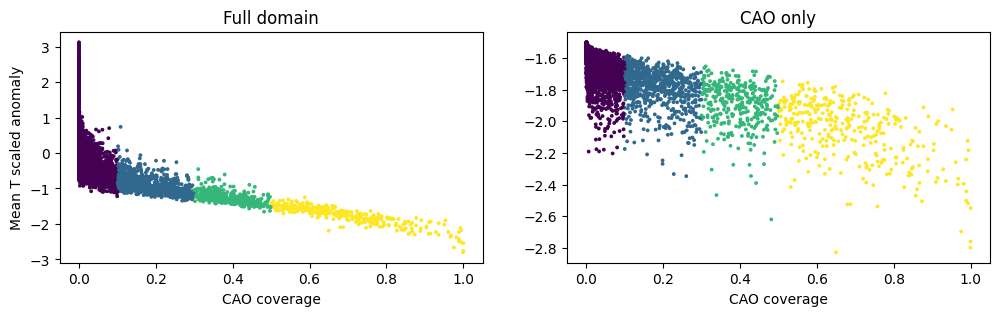

In [ ]:
fig, ax = plt.subplots(1,2,sharex=True,figsize=(12, 3))

ax[0].scatter(df['cao_area_weighted'],df['tanom_mean_weighted'],c=df['class_to_numeric'],s=3)
ax[0].set_title("Full domain")
ax[0].set_xlabel("CAO coverage")
ax[0].set_ylabel("Mean T scaled anomaly")

ax[1].scatter(df['cao_area_weighted'],df['tanom_cao'],c=df['class_to_numeric'],s=3)
ax[1].set_title("CAO only")
ax[1].set_xlabel("CAO coverage")

In [ ]:
df[df['class']=='strong'].sort_values('tanom_cao')[['time','tanom_cao','cao_area_weighted']]

,time,tanom_cao,cao_area_weighted
16457,1985-01-21,-2.826842,0.649871
15357,1982-01-17,-2.798209,0.999425
19742,1994-01-19,-2.758798,1.000000
19739,1994-01-16,-2.695745,0.975524
15358,1982-01-18,-2.548147,1.000000
...,...,...,...
13486,1976-12-03,-1.771487,0.559915
15010,1981-02-04,-1.769145,0.563224
23764,2005-01-23,-1.768768,0.555124
16452,1985-01-16,-1.756150,0.576433


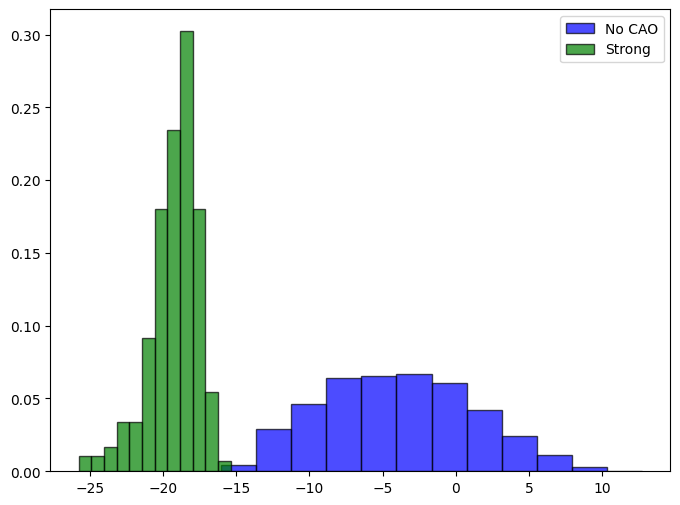

In [ ]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df['t2min'][df['class']=='no_cao'], bins=12, color='blue', edgecolor='black', alpha=0.7,density=True,label="No CAO")
#plt.hist(df['t2min'][df['class']=='moderate'], bins=12, color='red', edgecolor='black', alpha=0.7,density=True,label="Moderate")
plt.hist(df['t2min'][df['class']=='strong'], bins=12, color='green', edgecolor='black', alpha=0.7,density=True,label="Strong")
plt.legend()
plt.show()


In [ ]:
df["month"] = df.time.dt.month
df[df['class']!='no_cao'].groupby('month')['month'].count()

month
1     674
2     479
3     102
11      3
12    234
Name: month, dtype: int64

In [ ]:
df[df["class"]!="no_cao"].groupby("year")["class"].count().sort_values()

year
2021.0     2
2020.0     3
1998.0     4
2006.0     4
1953.0     4
          ..
1981.0    33
1963.0    35
2014.0    35
1994.0    37
1977.0    40
Name: class, Length: 81, dtype: int64

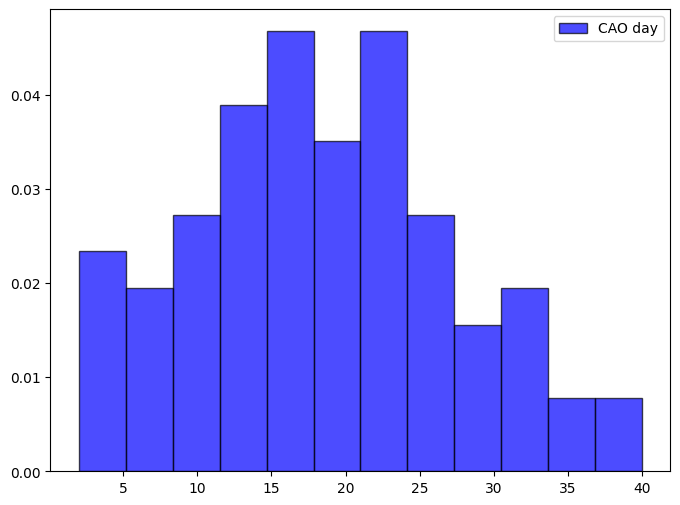

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df[df["class"]!="no_cao"].groupby("year")["class"].count(), bins=12, color='blue', edgecolor='black', alpha=0.7,density=True,label="CAO day")
plt.legend()
plt.show()

Text(0.5, 1.0, 'T2min avg')

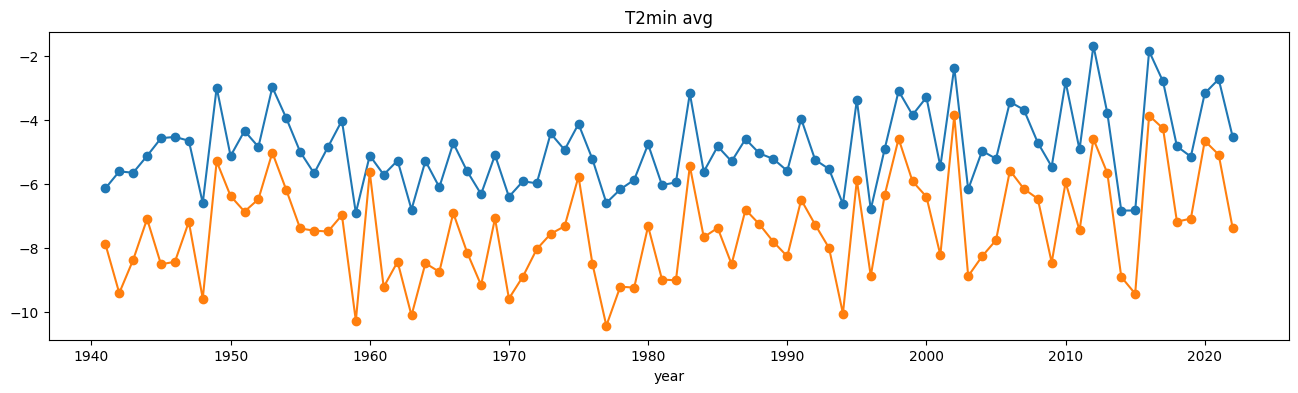

In [ ]:
plt.figure(figsize=(16,4))
df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df[df.time.dt.month.isin([1,12,2])].groupby("year")["t2min_weighted"].mean().plot(style='-o',label="DJF")
plt.title("T2min avg")

In [ ]:
df['day'] = df.groupby('year').cumcount()

In [ ]:
data = df.pivot(columns='day',values='class_to_numeric',index='year')


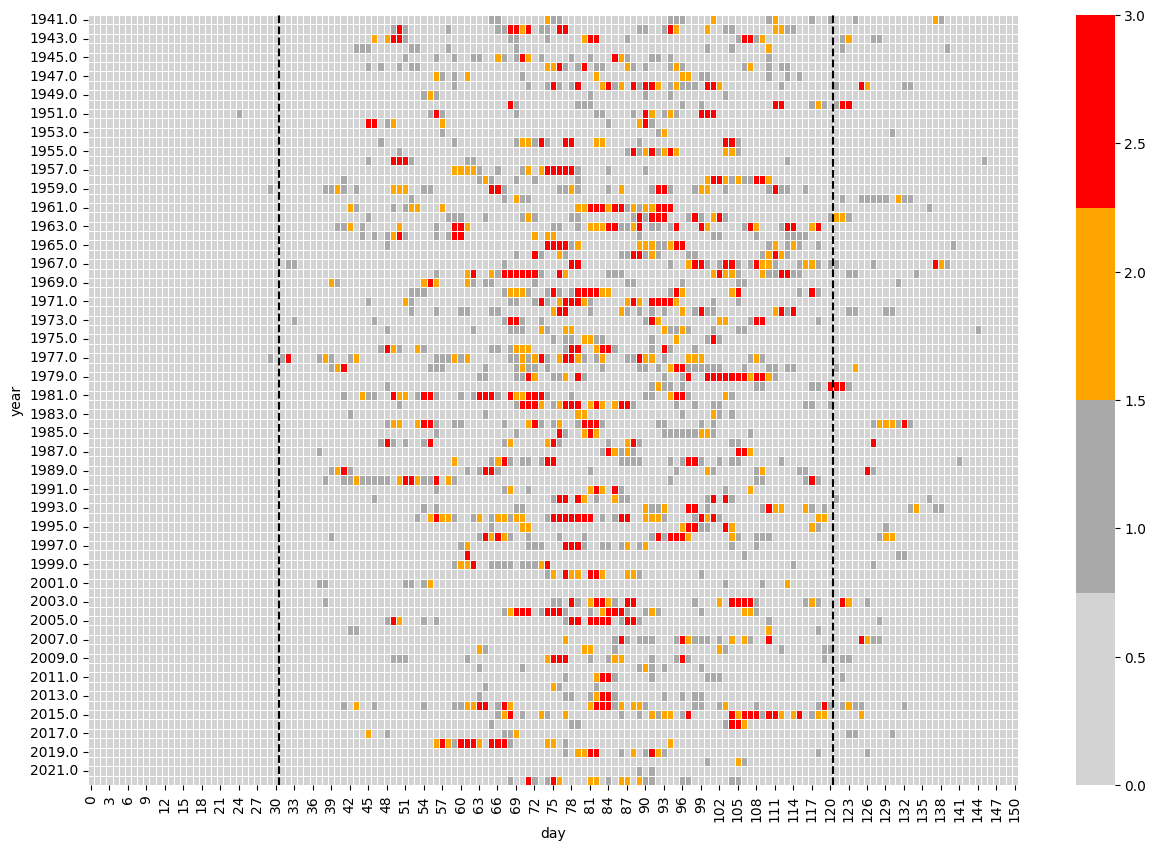

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(data, 
                cmap=sns.color_palette(list(class_colors.values()), as_cmap=True),

linewidths=.5)
plt.yticks(fontsize=10)  
plt.axvline(31,color='black',linestyle='--')
plt.axvline(121,color='black',linestyle='--')
plt.show()

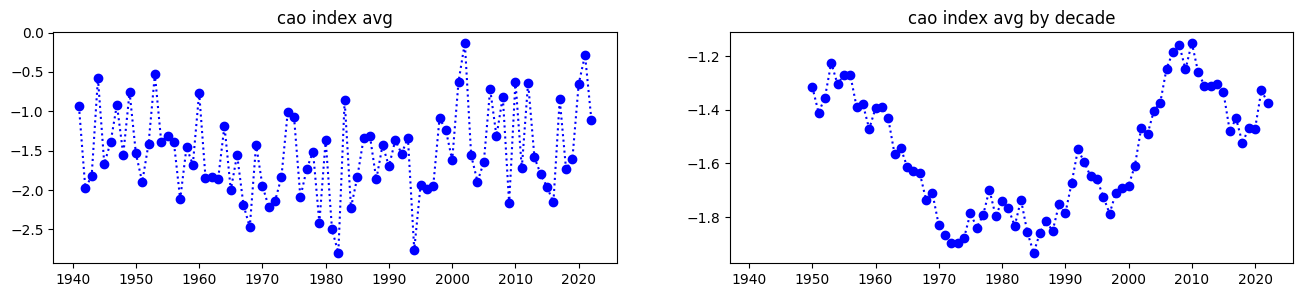

In [ ]:

t_trend = df.groupby(["year"],as_index=False).agg({'year': 'mean', 'cao_index': 'min'})
t_trend["rolling"] = t_trend["cao_index"].rolling(10).mean()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].plot(t_trend['year'],t_trend['cao_index'],'o:b')
ax[0].set_title('cao index avg')

ax[1].plot(t_trend['year'],t_trend['rolling'],'o:b')
ax[1].set_title('cao index avg by decade');

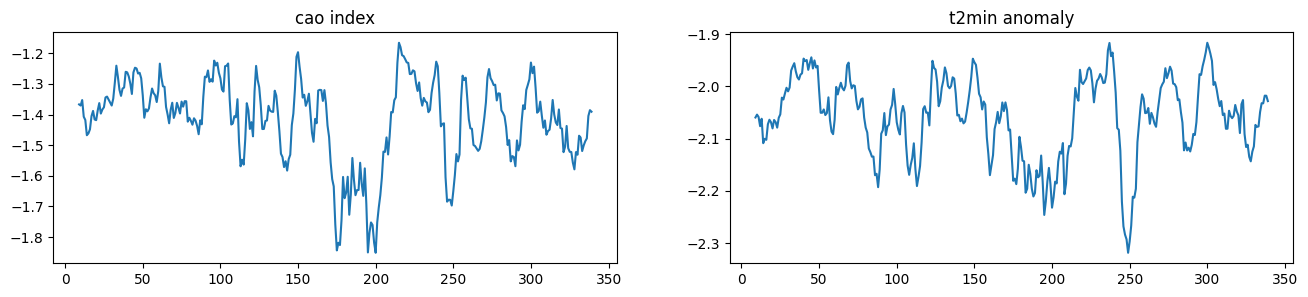

In [ ]:
fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))


y=df[df['class']=='strong']['cao_index']
y_roll = y.rolling(10).mean()
x=range(0,len(y))


ax[0].plot(x,y_roll)
ax[0].set_title('cao index')


y=df[df['class']=='strong']['tanom_cao']
y_roll = y.rolling(10).mean()

ax[1].plot(x,y_roll)
ax[1].set_title('t2min anomaly');

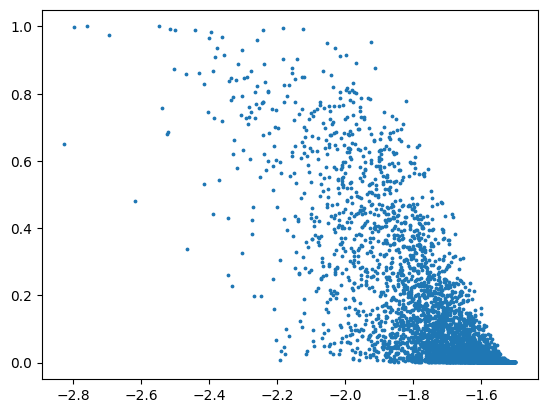

In [ ]:
plt.scatter((df['tanom_cao']),df['cao_area_weighted'],s=3)
#plt.axhline(0.4)
#plt.axvline(-2)

<Axes: >

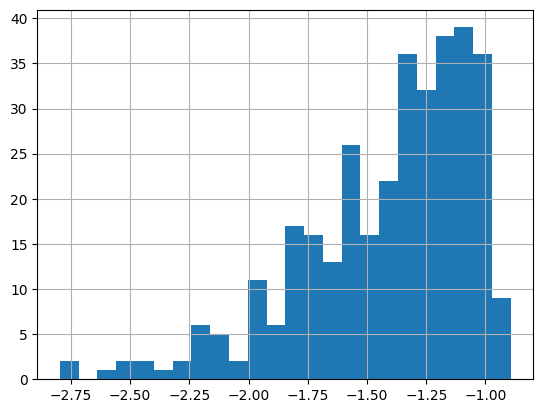

In [ ]:
df.loc[df['class']=='strong','cao_index'].hist(bins=24)

In [ ]:
(df.sort_values('cao_index')[['time','tanom_cao','cao_area_weighted','cao_index']]).head(30)

,time,tanom_cao,cao_area_weighted,cao_index
15357,1982-01-17,-2.798209,0.999425,-2.796601
19742,1994-01-19,-2.758798,1.000000,-2.758798
19739,1994-01-16,-2.695745,0.975524,-2.629765
15358,1982-01-18,-2.548147,1.000000,-2.548147
14979,1981-01-04,-2.517184,0.993413,-2.500604
10234,1968-01-08,-2.501128,0.988671,-2.472791
14286,1979-02-11,-2.443114,0.988719,-2.415553
14969,1980-12-25,-2.394368,0.982198,-2.351743
15350,1982-01-10,-2.399692,0.966709,-2.319804
14292,1979-02-17,-2.362181,0.968059,-2.286731


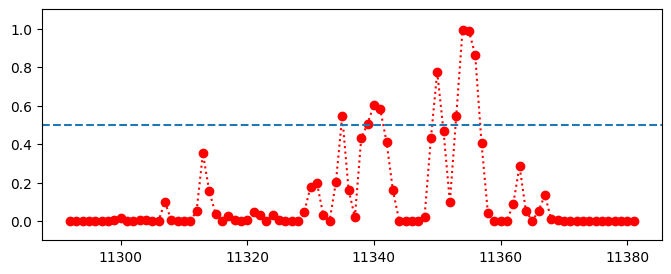

In [ ]:
start = '1970-12-01'
end = '1971-02-28'

plt.figure(figsize=(8,3))
plt.plot(df.loc[(df.time>=start) & (df.time<=end),"cao_area_weighted"],"o:r")
plt.ylim(-0.1, 1.1)
plt.axhline(0.5,linestyle='--')
plt.show()

In [ ]:
df.sort_values('tanom_cao')

,time,cao_area_simple,cao_area_weighted,cao_area_gaussian,t2min_cao,tanom_cao,tanom_mean,tanom_mean_weighted,t2min,t2min_weighted,t2min_gaussian,t2min_min,t2min_q05,year,class,class_to_numeric,month,decade,day
16457,1985-01-21,0.627576,0.649871,0.640071,-19.451528,-2.826842,-4.843762,-2.188378,-20.921250,-20.710189,-294.159729,-32.783478,-303.527576,1985.0,strong,3,1,1980,81
15357,1982-01-17,0.999419,0.999425,0.999357,-25.222166,-2.798209,-4.848628,-2.797442,-25.747147,-25.221155,-298.711551,-41.880554,-313.417932,1982.0,strong,3,1,1980,77
19742,1994-01-19,1.000000,1.000000,1.000000,-24.962545,-2.758798,-4.733095,-2.758798,-25.402023,-24.962551,-298.453164,-38.149277,-310.191953,1994.0,strong,3,1,1990,79
19739,1994-01-16,0.972714,0.975524,0.976981,-24.282768,-2.695745,-4.234081,-2.661144,-24.889938,-24.401486,-298.049238,-37.756270,-309.440594,1994.0,strong,3,1,1990,76
16456,1985-01-20,0.463570,0.481502,0.467672,-19.549792,-2.619352,-3.928203,-1.653479,-18.049377,-17.753757,-291.048417,-31.167053,-303.038501,1985.0,moderate,2,1,1980,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30035,2022-03-26,0.000000,0.000000,0.000000,NaN,NaN,0.467087,1.346267,1.266418,1.567279,-271.672209,-13.904480,-282.674207,2022.0,no_cao,0,3,2020,145
30036,2022-03-27,0.000000,0.000000,0.000000,NaN,NaN,-0.433168,0.519466,-4.480194,-4.068750,-277.504958,-21.399780,-292.443167,2022.0,no_cao,0,3,2020,146
30037,2022-03-28,0.000000,0.000000,0.000000,NaN,NaN,-1.352898,-0.223096,-8.933075,-8.542840,-282.079511,-21.265350,-292.890051,2022.0,no_cao,0,3,2020,147
30039,2022-03-30,0.000000,0.000000,0.000000,NaN,NaN,-1.111082,0.454781,-4.471252,-4.085379,-277.743360,-18.874512,-288.954175,2022.0,no_cao,0,3,2020,149


In [ ]:
cao_mtly = df.pivot_table(values="t2min",columns = "class",index=["year"],aggfunc="count",fill_value=0)
cao_mtly.iloc[49]

class
moderate      4
no_cao      127
strong        4
weak         16
Name: 1990.0, dtype: int64

# Autocorrelation

In [ ]:
img_path = "prelim_results/"

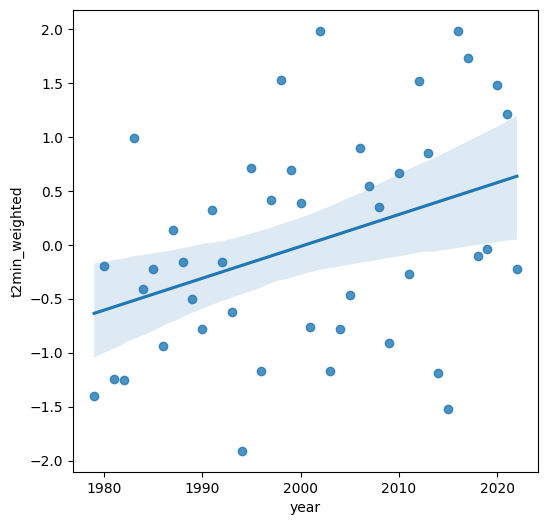

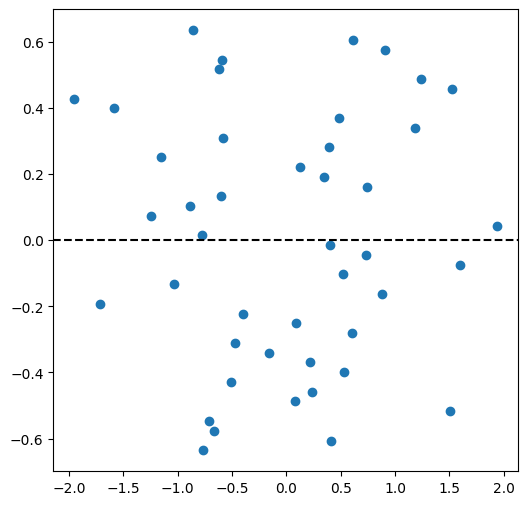

<Figure size 600x600 with 0 Axes>

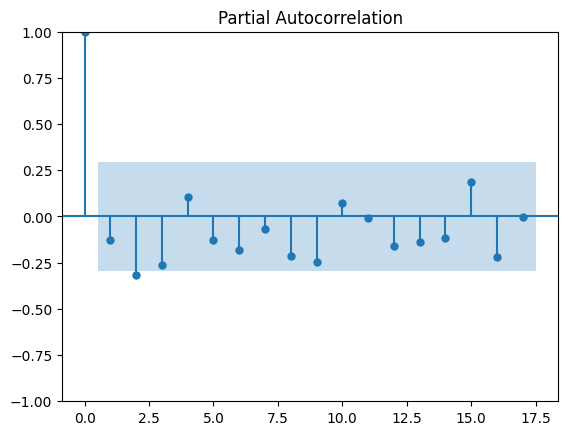

In [ ]:
df_seas = df[df.time.dt.month.isin([1,12,2])].groupby("year")[["t2min_weighted","year"]].mean()

#exp_name = "full"

df_seas = df_seas[df_seas.year>=1979]
exp_name = "t2min_1979_2022"

#df_seas = df_seas[df_seas.year<1979]
#exp_name = "t2min_1940_1978"


df_seas["t2min_weighted"] = (df_seas["t2min_weighted"] - np.mean(df_seas["t2min_weighted"]) )/np.std(df_seas["t2min_weighted"])
df_seas = sm.add_constant(df_seas, prepend=False)


plt.figure(figsize=(6, 6))
sns.regplot(x='year',y='t2min_weighted',data=df_seas)
plt.savefig("{}seas_{}.png".format(img_path,exp_name))

mod = sm.OLS( df_seas.t2min_weighted,df_seas[['year','const']]).fit()
res = df_seas.t2min_weighted - mod.fittedvalues
plt.figure(figsize=(6, 6))
plt.scatter(res, mod.fittedvalues)
plt.axhline(0,color='black',linestyle='--')
plt.savefig("{}res_{}.png".format(img_path,exp_name))

plt.figure(figsize=(6, 6))
plot_pacf(res)
plt.savefig("{}res_auto_{}.png".format(img_path,exp_name))

In [ ]:
years_future = list(range(2023,2301,1))

In [ ]:
a, b = mod.params
res_std = np.std(res)
y_projection = np.ones(len(years_future))
for i,y in enumerate(years_future):
    y_projection[i] = a*y+b

In [ ]:
df_seas = df[(df["class"]=="moderate") | (df["class"]=="strong")].groupby("year")[["cao_area_weighted"]].count()
df_seas["year"] = df[(df["class"]=="moderate") | (df["class"]=="strong")].groupby("year")[["year"]].mean()
exp_name = "full"

#df_seas = df_seas[df_seas.year>=1979]
#exp_name = "t2min_1979_2022"

#df_seas = df_seas[df_seas.year<1979]
#exp_name = "t2min_1940_1978"

#df_seas = df_seas[df_seas.year>=1999]
#exp_name = "t2min_1999_2022"

#df_seas["t2min_weighted"] = (df_seas["t2min_weighted"] - np.mean(df_seas["t2min_weighted"]) )/np.std(df_seas["t2min_weighted"])
df_seas = sm.add_constant(df_seas, prepend=False)

mod = sm.OLS( df_seas.cao_area_weighted,df_seas[['year','const']]).fit()
res = df_seas.cao_area_weighted - mod.fittedvalues

<Axes: xlabel='year', ylabel='cao_area_weighted'>

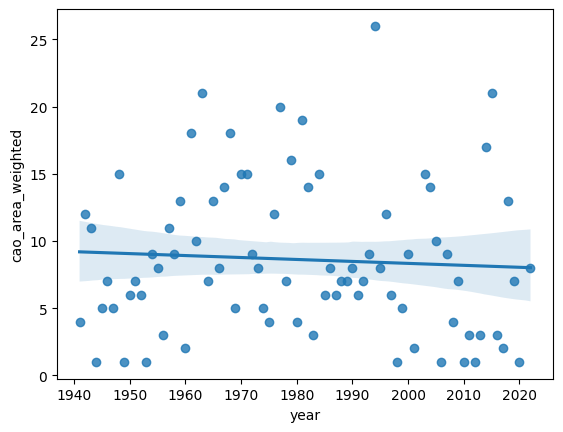

In [ ]:
sns.regplot(x='year',y='cao_area_weighted',data=df_seas)

In [ ]:
years_future = list(range(1940,2300,1))

In [ ]:
a, b = mod.params
res_std = np.std(res)
N = 10000
y_projection = np.ones((len(years_future),N))
for i,y in enumerate(years_future):
    y_projection[i,:] = np.random.normal(a*y+b,res_std,N)

In [ ]:
mean_values = list(map(np.mean,y_projection))
std_values = list(map(np.std,y_projection))
mean_ci = [(1.96*arr)/(np.sqrt(N)) for arr in std_values]
upper = [np.quantile(arr, .975) for arr in y_projection]
lower = [np.quantile(arr, .025) for arr in y_projection]

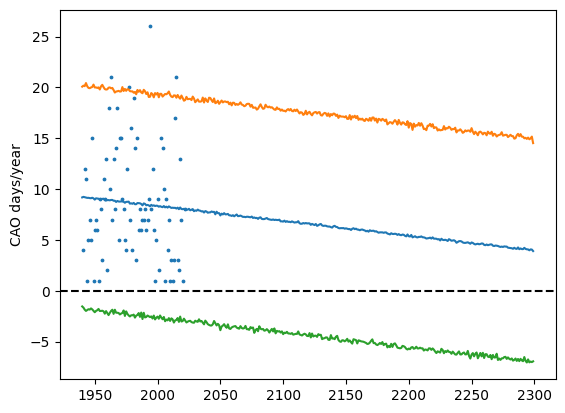

In [ ]:
plt.plot(years_future,mean_values)
plt.plot(years_future,upper)
plt.plot(years_future,lower)
plt.scatter(df_seas.year,df_seas["cao_area_weighted"],s=3)
plt.ylabel("CAO days/year")
plt.axhline(0,color='black',linestyle='--')

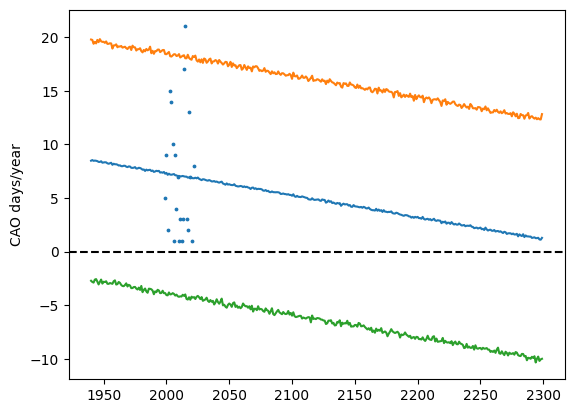

In [ ]:
plt.plot(years_future,mean_values)
plt.plot(years_future,upper)
plt.plot(years_future,lower)
plt.scatter(df_seas.year,df_seas["cao_area_weighted"],s=3)
plt.ylabel("CAO days/year")
plt.axhline(0,color='black',linestyle='--')

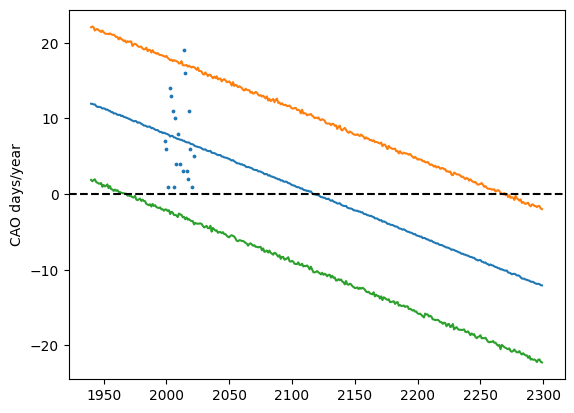

In [ ]:
plt.plot(years_future,mean_values)
plt.plot(years_future,upper)
plt.plot(years_future,lower)
plt.scatter(df_seas.year,df_seas["cao_area_weighted"],s=3)
plt.ylabel("CAO days/year")
plt.axhline(0,color='black',linestyle='--')

# Comparing with older version of the tracker

In [ ]:
df[df.time=='1989-12-01']

,time,cao_area_simple,cao_area_weighted,cao_area_gaussian,t2min_cao,tanom_cao,tanom_mean,tanom_mean_weighted,t2min,t2min_weighted,t2min_gaussian,t2min_min,t2min_q05,year,class,class_to_numeric,month,day
18232,1989-12-01,0.004064,0.003975,0.004519,-24.065189,-1.599904,-1.803897,-0.461754,-11.337036,-10.704571,-284.383604,-30.142883,-300.880042,1990.0,no_cao,0,12,30


In [ ]:
df_old = pd.read_csv("data/era5_data_old.csv",sep=";")
df_old[df_old.time=='1989-12-01']

,time,anomaly,min_anomaly,avg_std,avg_std_weighted,min_std,weighted_area_coverage,area_coverage,cao_group,cao_day,year
4482,1989-12-01,-7.877441,-20.802002,-1.368616,-1.345344,-3.061179,0.541119,0.558197,NaN,0.0,1990


In [ ]:
df

,time,cao_area_simple,cao_area_weighted,cao_area_gaussian,t2min_cao,tanom_cao,tanom_mean,tanom_mean_weighted,t2min,t2min_weighted,t2min_gaussian,t2min_min,t2min_q05,year,class,class_to_numeric,month,day
305,1940-11-01,0.000000,0.000000,0.000000,NaN,NaN,0.480770,1.649267,2.874725,3.262868,-270.247970,-14.186920,-282.213275,1941.0,no_cao,0,11,0
306,1940-11-02,0.000000,0.000000,0.000000,NaN,NaN,1.064418,2.033075,5.603271,5.909746,-267.399206,-8.113129,-275.891156,1941.0,no_cao,0,11,1
307,1940-11-03,0.000000,0.000000,0.000000,NaN,NaN,0.977465,1.931503,5.080261,5.332471,-267.978937,-2.742065,-274.359241,1941.0,no_cao,0,11,2
308,1940-11-04,0.000000,0.000000,0.000000,NaN,NaN,0.876619,1.769943,3.961609,4.235930,-269.213431,-6.855011,-276.271936,1941.0,no_cao,0,11,3
309,1940-11-05,0.000000,0.000000,0.000000,NaN,NaN,0.958613,2.159100,6.125305,6.497868,-266.847492,-8.235992,-277.490326,1941.0,no_cao,0,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30036,2022-03-27,0.000000,0.000000,0.000000,NaN,NaN,-0.433168,0.519466,-4.480194,-4.068750,-277.504958,-21.399780,-292.443167,2022.0,no_cao,0,3,146
30037,2022-03-28,0.000000,0.000000,0.000000,NaN,NaN,-1.352898,-0.223096,-8.933075,-8.542840,-282.079511,-21.265350,-292.890051,2022.0,no_cao,0,3,147
30038,2022-03-29,0.002322,0.002552,0.001828,5.364562,-1.600805,-1.693820,-0.207519,-8.597412,-8.251098,-281.704455,-21.949493,-292.315945,2022.0,no_cao,0,3,148
30039,2022-03-30,0.000000,0.000000,0.000000,NaN,NaN,-1.111082,0.454781,-4.471252,-4.085379,-277.743360,-18.874512,-288.954175,2022.0,no_cao,0,3,149


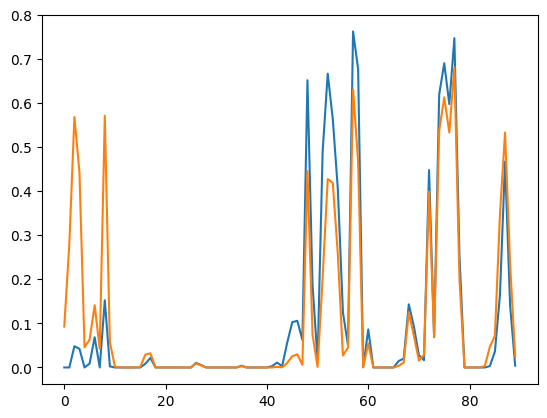

In [ ]:
target = df.loc[(df.time>='2002-12-01') & (df.time<='2003-02-28'),["time","cao_area_weighted"]].reset_index()
ref = df_old.loc[(df_old.time>='2002-12-01') & (df_old.time<='2003-02-28'),["time","weighted_area_coverage"]].reset_index()
plt.plot(target["cao_area_weighted"])
plt.plot(ref["weighted_area_coverage"])

In [ ]:
import xarray as xr

In [ ]:
ds = xr.open_dataset("data/subset_t2min.nc")

In [ ]:
ds

<xarray.Dataset> Size: 643MB
Dimensions:       (latitude: 57, longitude: 93, time: 30316)
Coordinates:
  * latitude      (latitude) float32 228B 50.0 49.75 49.5 ... 36.5 36.25 36.0
  * longitude     (longitude) float32 372B -91.0 -90.75 -90.5 ... -68.25 -68.0
  * time          (time) datetime64[ns] 243kB 1940-01-01 ... 2022-12-31
Data variables:
    daily_t2_min  (time, latitude, longitude) float32 643MB ...

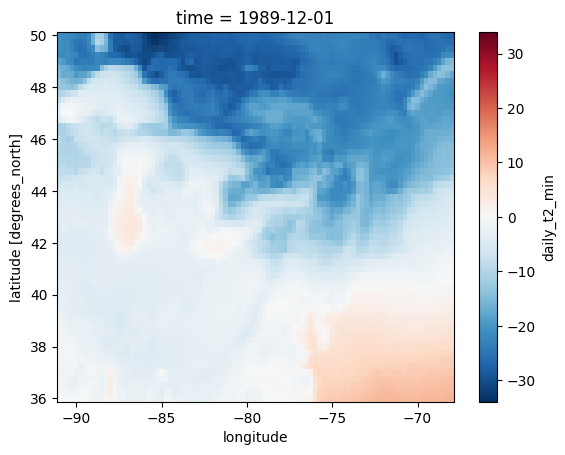

In [ ]:
(ds['daily_t2_min'].sel(time="1989-12-01")-273.15).plot()

# Checking old values

In [ ]:
df = pd.read_csv("data/era5_data_old.csv",sep=";")
df.time = pd.to_datetime(df.time)
df["class"] = "no_cao"
df.loc[df["weighted_area_coverage"]>0.5,"class"] = "strong"
df.loc[(df["weighted_area_coverage"]>=0.3) & (df["weighted_area_coverage"]<0.5),"class"] = "moderate"
df.loc[(df["weighted_area_coverage"]>=0.1) & (df["weighted_area_coverage"]<0.3),"class"] = "weak"
class_colors = {'no_cao': 'lightgrey', 'weak': 'darkgrey', 'moderate': 'orange', 'strong': 'red'}

# Map classes to numeric values
class_to_numeric = {'no_cao': 0, 'weak': 1, 'moderate': 2, 'strong': 3}
numeric_to_class = {v: k for k, v in class_to_numeric.items()}
df['class_to_numeric'] = df['class'].map(class_to_numeric)

# Comparing CAOs

In [ ]:
plt.hist(df.tanom_mean_weighted[(df["class"]=="strong") & (df.year > 1978)],bins=12,edgecolor='black')

AttributeError: 'DataFrame' object has no attribute 'tanom_mean_weighted'

(array([ 1.,  1.,  3.,  4.,  3.,  8., 14., 23., 32., 30., 15.,  2.]),
 array([-2.48500139, -2.38324073, -2.28148007, -2.17971941, -2.07795876,
        -1.9761981 , -1.87443744, -1.77267678, -1.67091612, -1.56915546,
        -1.4673948 , -1.36563414, -1.26387348]),
 <BarContainer object of 12 artists>)

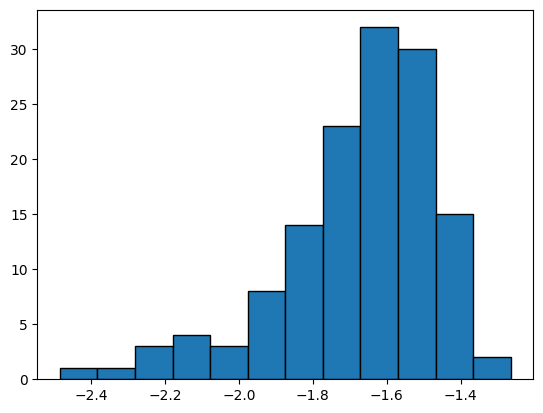

In [ ]:
plt.hist(df.tanom_mean_weighted[(df["class"]=="strong") & (df.year <= 1978)],bins=12,edgecolor='black')

(array([ 2.,  0.,  0.,  1.,  0.,  2.,  2.,  3.,  5.,  6., 10.,  4., 14.,
        25., 22., 40., 49., 45., 27., 12.,  4.,  1.,  0.,  1.]),
 array([-2.92917288, -2.84964559, -2.7701183 , -2.69059102, -2.61106373,
        -2.53153644, -2.45200915, -2.37248186, -2.29295457, -2.21342728,
        -2.1339    , -2.05437271, -1.97484542, -1.89531813, -1.81579084,
        -1.73626355, -1.65673626, -1.57720898, -1.49768169, -1.4181544 ,
        -1.33862711, -1.25909982, -1.17957253, -1.10004524, -1.02051796]),
 <BarContainer object of 24 artists>)

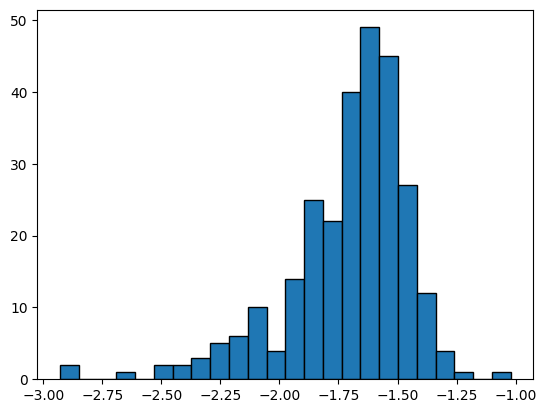

In [ ]:
plt.hist(df.tanom_mean_weighted[df["class"]=="strong"],bins=24,edgecolor='black')

Text(0.5, 1.0, 'Strong CAO days by year')

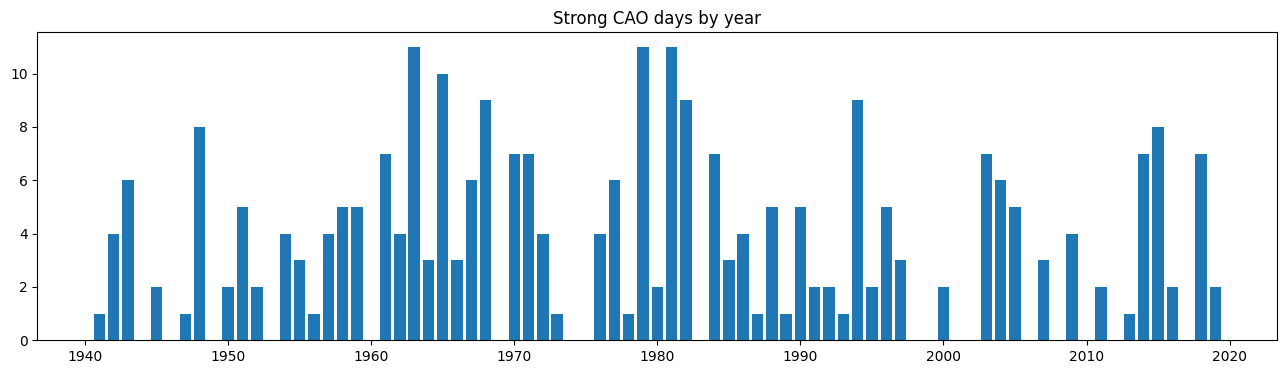

In [ ]:
df_plot=df[(df["class"]=="strong")].groupby("year", as_index=False)["tanom_mean_weighted"].count()
df_plot
plt.figure(figsize=(16,4))
plt.bar(df_plot['year'],df_plot['tanom_mean_weighted'])
plt.title("Strong CAO days by year")

Text(0.5, 1.0, 'Moderate CAO days by year')

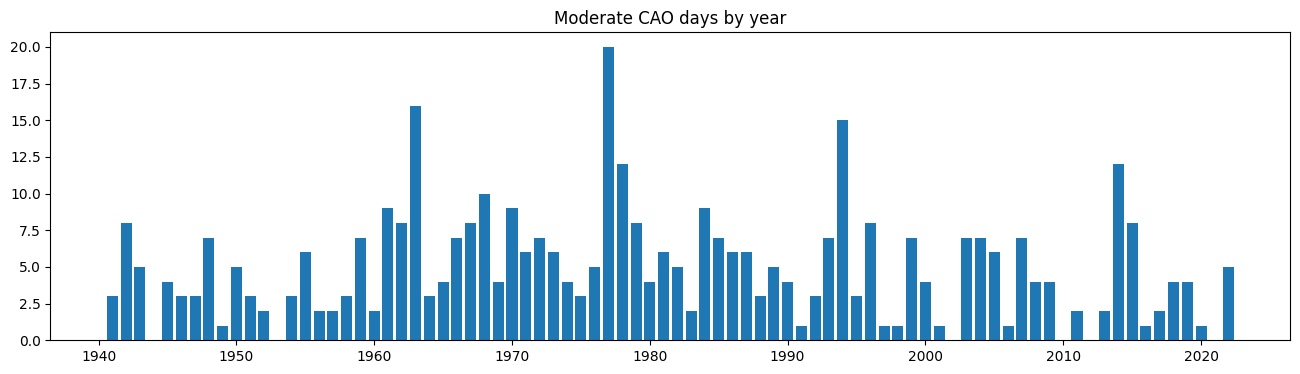

In [ ]:
df_plot=df[(df["class"]=="moderate")].groupby("year", as_index=False)["tanom_mean_weighted"].count()
df_plot
plt.figure(figsize=(16,4))
plt.bar(df_plot['year'],df_plot['tanom_mean_weighted'])
plt.title("Moderate CAO days by year")

Text(0.5, 1.0, 'T2min avg')

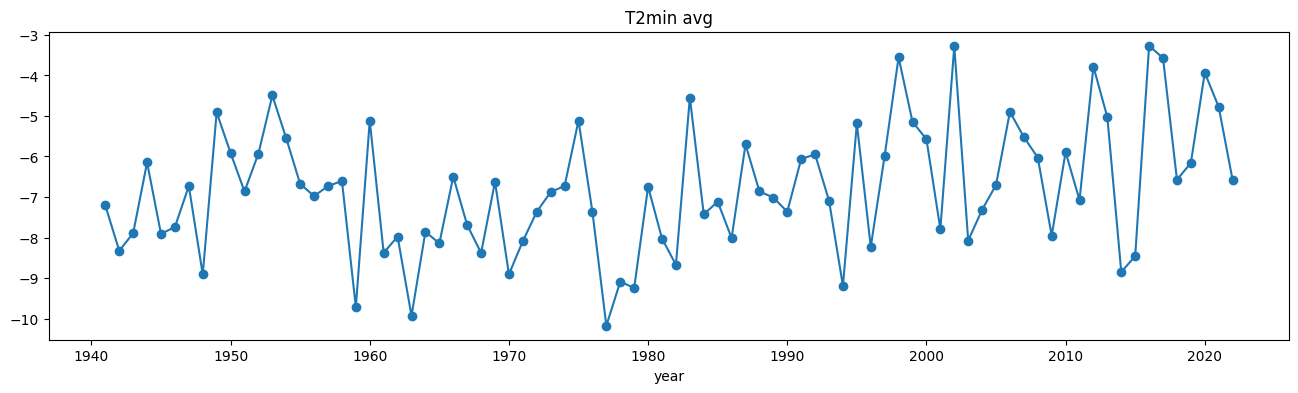

In [ ]:
plt.figure(figsize=(16,4))
#df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df[df.time.dt.month.isin([1,12,2])].groupby("year")["t2min_weighted"].mean().plot(style='-o',label="DJF")
plt.title("T2min avg")

Text(0.5, 1.0, 'p005')

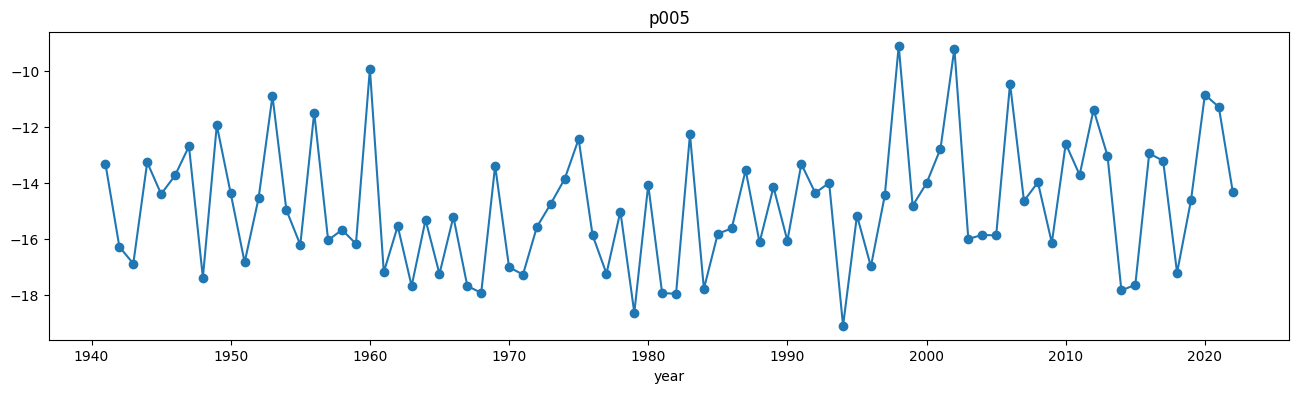

In [ ]:
plt.figure(figsize=(16,4))
#df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df[df.time.dt.month.isin([1,12,2])].groupby("year")["t2min_weighted"].quantile(q=0.05).plot(style='-o',label="DJF")
plt.title("p005")

Text(0.5, 1.0, 'area p95')

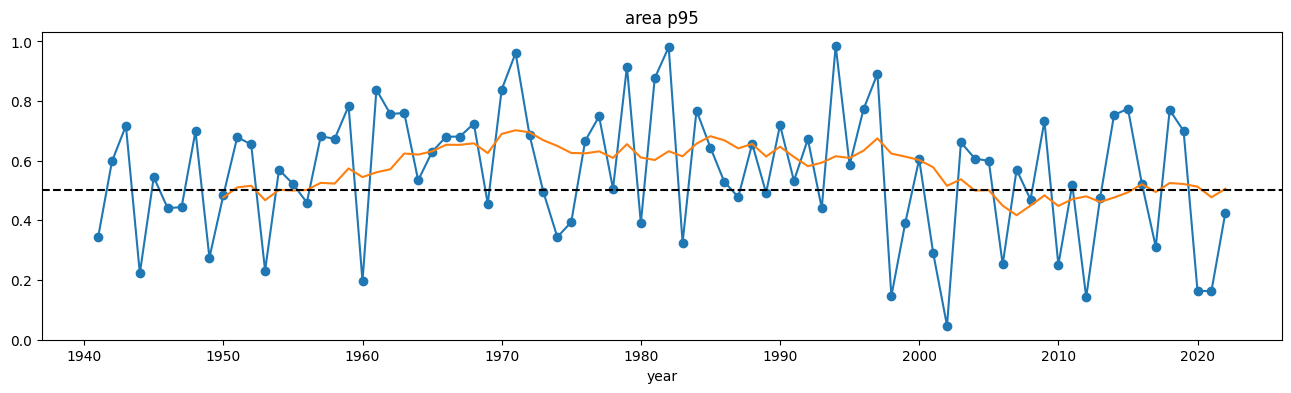

In [ ]:
plt.figure(figsize=(16,4))
#df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df_plot = df[df.time.dt.month.isin([1,12,2])].groupby("year")["cao_area_weighted"].quantile(q=0.99)
df_plot.plot(style='-o')
df_plot.rolling(10).mean().plot()
plt.axhline(0.5,color='black',linestyle='--')
plt.title("area p95")

Text(0.5, 1.0, 'CAO max area')

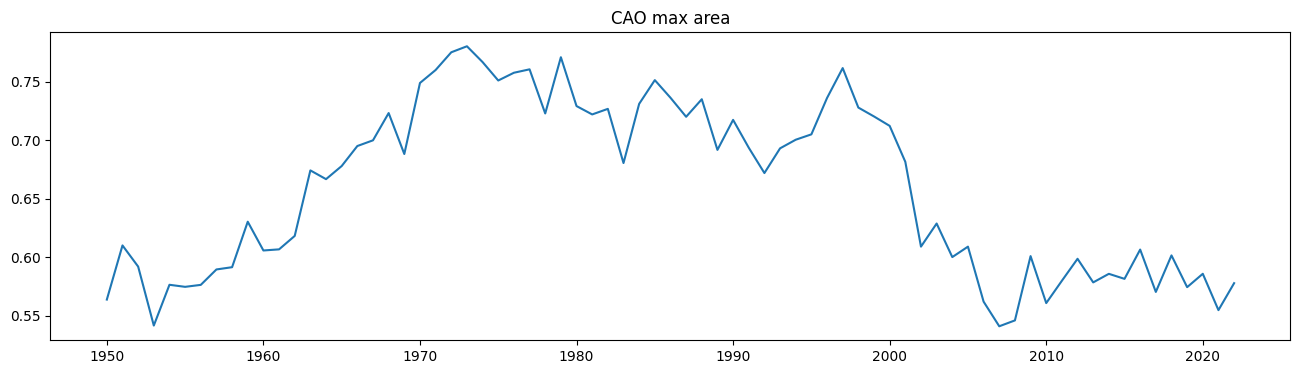

In [ ]:
df_plot = df[df.time.dt.month.isin([1,12,2])].groupby("year")["cao_area_weighted"].max().rolling(10).mean()
plt.figure(figsize=(16,4))
plt.plot(df_plot)
plt.title("CAO max area")

Text(0.5, 1.0, 'area max')

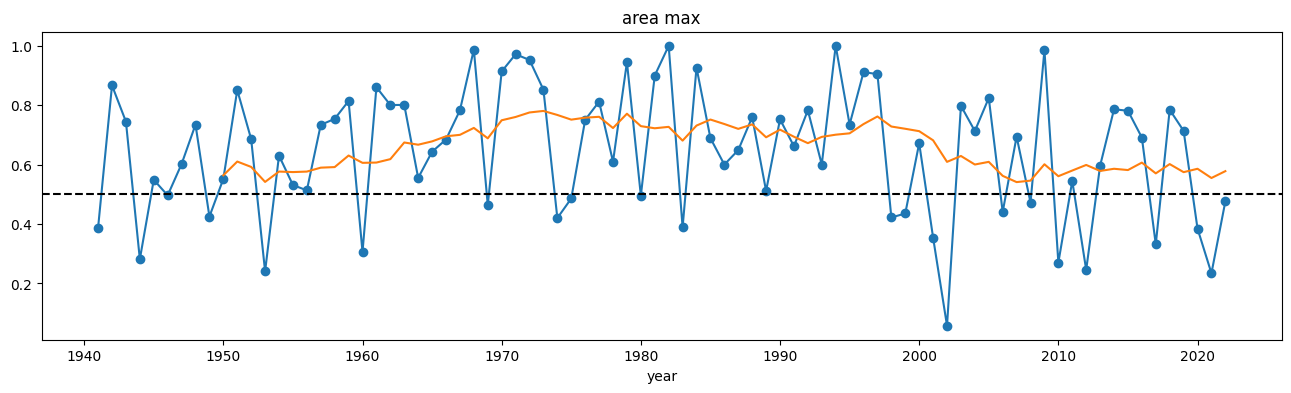

In [ ]:
plt.figure(figsize=(16,4))
#df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df[df.time.dt.month.isin([1,12,2])].groupby("year")["cao_area_weighted"].max().plot(style='-o')
df_plot = df[df.time.dt.month.isin([1,12,2])].groupby("year")["cao_area_weighted"].max().rolling(10).mean()
plt.plot(df_plot)
plt.axhline(0.5,color='black',linestyle='--')

plt.title("area max")

Text(0.5, 1.0, 'area max')

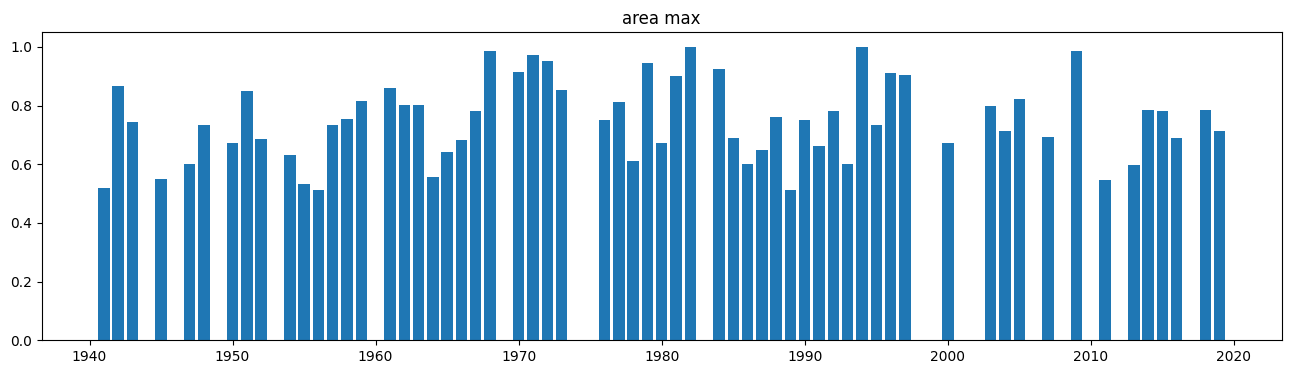

In [ ]:
plt.figure(figsize=(16,4))
#df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df_plot=df[df["class"]=="strong"].groupby("year",as_index=False)["cao_area_weighted"].max()
plt.bar(df_plot['year'],df_plot['cao_area_weighted'])
plt.title("area max")

Text(0.5, 1.0, 'strong cao tanom mean')

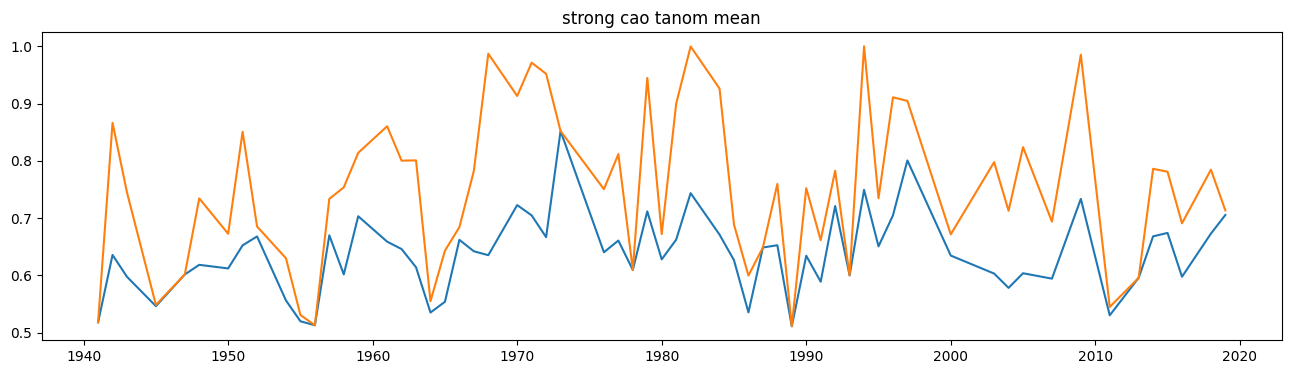

In [ ]:
plt.figure(figsize=(16,4))
#df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df_plot=df[df["class"]=="strong"].groupby("year",as_index=False)["cao_area_weighted"].mean()
df_plot2=df[df["class"]=="strong"].groupby("year",as_index=False)["cao_area_weighted"].max()
plt.plot(df_plot['year'],df_plot['cao_area_weighted'])
plt.plot(df_plot2['year'],df_plot2['cao_area_weighted'])
plt.title("strong cao tanom mean")
#plt.axhline(-1.5,color='black',linestyle='--')


Text(0.5, 1.0, 'strong cao tanom mean')

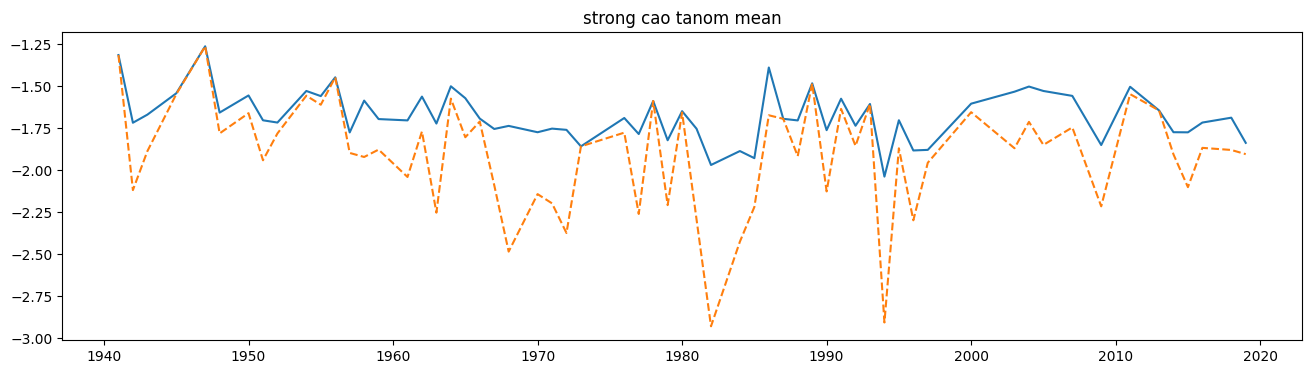

In [ ]:
plt.figure(figsize=(16,4))
#df.groupby("year")["t2min_weighted"].mean().plot(style='-o')
df_plot=df[df["class"]=="strong"].groupby("year",as_index=False)["tanom_mean_weighted"].mean()
df_plot2=df[df["class"]=="strong"].groupby("year",as_index=False)["tanom_mean_weighted"].min()

plt.plot(df_plot['year'],df_plot['tanom_mean_weighted'])
plt.plot(df_plot2['year'],df_plot2['tanom_mean_weighted'],linestyle='--')

plt.title("strong cao tanom mean")
#plt.axhline(-2,color='black',linestyle='--')

Check the impact of 2014/2015 in the results